In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import MaxNLocator

import warnings
warnings.filterwarnings('ignore')

import re

In [18]:
def compute_CUSUM(X):
    CUSUM = np.cumsum(X**2)
    return CUSUM

def compute_gamma(X, T, m):
    mean_X = np.mean(X)
    r = X - mean_X  # 잔차 계산
    r_squared = r ** 2
    sigma_squared = np.mean(r_squared)

    gamma = np.zeros(m+1)
    for i in range(0, m + 1):
        gamma_i = np.sum((r_squared[i:T] - sigma_squared) * (r_squared[0:T-i] - sigma_squared))
        gamma[i] = gamma_i / T
    return gamma

def compute_lambda(gamma, m):
    lambda_hat = gamma[0] + 2 * np.sum((1 - np.arange(1, m+1) / (m+1)) * gamma[1:m+1])
    return lambda_hat

def compute_D_prime(CUSUM, T, lambda_hat):
    k = np.arange(T)
    D_prime = (CUSUM - (k + 1) / T * CUSUM[-1]) / np.sqrt(lambda_hat)
    return D_prime

def compute_percentile(D_prime, T , percent = 95):
    D_prime_abs = np.abs(D_prime)* np.sqrt(T / 2)
    critical_value = np.percentile(D_prime_abs, percent)
    return critical_value

In [19]:
def ol_detect(hour_df, diff_value, window_size, significant_level,col_name,safran_df):
    
    lambda_lst = []
    cv_lst = []
    current_lst = []

    ol_lst = []

    for i in tqdm(range(window_size,len(diff_value)+1,1)):
    
        count = 0
        filter = []
        for val in ol_lst:
            if (i-window_size<=val) and (val<i):
                count +=1
                filter.append(val - (i))

        X = diff_value[i - window_size - count : i].copy()

        if len(filter) !=0:
            X = np.delete(X, filter)
            
        N = len(X)
        T = N
        m = int(T**(1/4))

        # CUSUM 계산
        CUSUM = compute_CUSUM(X)
        # gamma 계산
        gamma = compute_gamma(X, T, m)
        # lambda_hat 계산
        lambda_hat = compute_lambda(gamma, m)
        lambda_lst.append(lambda_hat)
        # D_prime 계산
        D_prime = compute_D_prime(CUSUM, T, lambda_hat)
        # critical value 계산
        critical_value = compute_percentile(D_prime, T ,significant_level)
        cv_lst.append(critical_value)
        # 현재 통계량 계산
        current_lst.append(np.abs(D_prime[-2]) * np.sqrt(T / 2))

        if current_lst[-1] > critical_value:
            ol_lst.append(i-1)
            
    ol_lst = list(np.where((np.array(current_lst) > np.array(cv_lst)))[0] + window_size)

    plt.figure(figsize=(12,1.5),dpi=400)
    plt.plot(hour_df[col_name],color='tab:blue')

    for point in ol_lst:
        plt.axvline(hour_df.index[point], color='tab:red', linewidth=0.5, linestyle='--')
        plt.scatter(hour_df.index[point], hour_df[col_name].iloc[point], color='tab:red', s=10)

    # 사프란 선 긋기 ----------------------------------------------------------------------------------------------------------------------------------
    # for time in safran_df.index:
    #     plt.axvline(time, color='tab:green', linewidth=0.5, linestyle='--')

    plt.title(str(int(window_size//(24 * 7))) + ' week, ' + str(int(significant_level)) + '% threshold')
    plt.xlabel('Date')
    plt.ylabel('Degree')

    # Y 축 범위 설정 ----------------------------------------------------------------------------------------------------------------------------------
    # plt.ylim(hour_df[col_name].mean() - 0.02 , hour_df[col_name].mean() +0.02)


    plt.show()

In [20]:
"""----------------------------------------------------------------------------------------------------------------------------------
2024년만 보기
----------------------------------------------------------------------------------------------------------------------------------"""

def ol_detect_2024(hour_df, diff_value, window_size, significant_level,col_name,safran_df):
    
    lambda_lst = []
    cv_lst = []
    current_lst = []

    ol_lst = []

    ol_lst_time = []

    for i in tqdm(range(window_size,len(diff_value)+1,1)):
    
        count = 0
        filter = []
        for val in ol_lst:
            if (i-window_size<=val) and (val<i):
                count +=1
                filter.append(val - (i))

        X = diff_value[i - window_size - count : i].copy()

        if len(filter) !=0:
            X = np.delete(X, filter)
            
        N = len(X)
        T = N
        m = int(T**(1/4))

        # CUSUM 계산
        CUSUM = compute_CUSUM(X)
        # gamma 계산
        gamma = compute_gamma(X, T, m)
        # lambda_hat 계산
        lambda_hat = compute_lambda(gamma, m)
        lambda_lst.append(lambda_hat)
        # D_prime 계산
        D_prime = compute_D_prime(CUSUM, T, lambda_hat)
        # critical value 계산
        critical_value = compute_percentile(D_prime, T ,significant_level)
        cv_lst.append(critical_value)
        # 현재 통계량 계산
        current_lst.append(np.abs(D_prime[-2]) * np.sqrt(T / 2))

        if current_lst[-1] > critical_value:
            ol_lst.append(i-1)
            
    ol_lst = list(np.where((np.array(current_lst) > np.array(cv_lst)))[0] + window_size)

    # PLOT 함수
    plt.figure(figsize=(12,1.5),dpi=400)
    plt.plot(hour_df[col_name][hour_df[col_name].index>='2024-01-01'],color='tab:blue')

    # Y 축 범위 설정 ----------------------------------------------------------------------------------------------------------------------------------
    # plt.ylim(hour_df[col_name].mean() - 0.02 , hour_df[col_name].mean() +0.02)

    for point in ol_lst:
        if (hour_df.index[point] >=pd.to_datetime('2024-01-01')):
            ol_lst_time.append(hour_df.index[point])
            # print('ICSS-----' + str(hour_df.index[point]))
            plt.axvline(hour_df.index[point], color='tab:red', linewidth=0.5, linestyle='--')
            plt.scatter(hour_df.index[point], hour_df[col_name].iloc[point], color='tab:red', s=10)

    # 사프란 선 긋기 ----------------------------------------------------------------------------------------------------------------------------------
    for time in safran_df.index:
        if (time >=pd.to_datetime('2024-01-01')):
            # print('safran-----' + str(time))
            plt.axvline(time, color='tab:green', linewidth=0.5, linestyle='--')

    plt.title(col_name + ' '+ str(int(window_size//(24 * 7))) + ' week, ' + str(int(significant_level)) + '% threshold')
    plt.xlabel('Date')
    plt.ylabel('Degree')

    plt.show()  

    return 

    print('---------------------')

    print(len(ol_lst))
    
    tolerances = [pd.Timedelta(hours=6), pd.Timedelta(hours=12), pd.Timedelta(hours=24)]
    results = {}

    for tolerance in tolerances:
        tp = 0  # True Positive
        fp = 0  # False Positive
        fn = 0  # False Negative

        # 실제 이벤트를 기준으로 탐지된 이벤트 확인 (True Positive와 False Negative 계산)
        for time in safran_df.index:
            if time >= pd.to_datetime('2024-01-01'):
                # 탐지된 이벤트 중 오차 범위 내에 있는지 확인
                time_diff = np.abs(hour_df.index[ol_lst] - time)
                if time_diff.min() <= tolerance:
                    tp += 1  # 오차 범위 내에 있으면 TP 증가
                else:
                    fn += 1  # 오차 범위 내에 없으면 FN 증가

        # 탐지된 이벤트 중 실제 이벤트와 매칭되지 않은 것들 계산 (False Positive)
        for point in ol_lst:
            detection_time = hour_df.index[point]
            if detection_time >= pd.to_datetime('2024-01-01'):
                # 실제 이벤트와 매칭되지 않는 탐지된 이벤트가 있는지 확인
                time_diff = np.abs(safran_df.index - detection_time)
                if time_diff.min() > tolerance:
                    fp += 1  # 오차 범위 내에 매칭되지 않으면 FP 증가

        # Precision과 Recall 계산
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0

        # 결과 저장
        results[f'±{tolerance.components.hours} hours'] = {
            'TP': tp,
            'FP': fp,
            'FN': fn,
            'Precision': precision,
            'Recall': recall
        }

    # 결과 출력
    for key, value in results.items():
        print(f"{key}:")
        print(f"  Precision: {value['Precision']:.4f}")
        print(f"  Recall: {value['Recall']:.4f}")
        print(f"  TP: {value['TP']}, FP: {value['FP']}, FN: {value['FN']}\n")



In [21]:
"""----------------------------------------------------------------------------------------------------------------------------------
2024년만 보기
----------------------------------------------------------------------------------------------------------------------------------"""

def ol_detect_2024_KT(hour_df, diff_value, window_size, significant_level,col_name,safran_df,kt_datas,y_label,filter_mode):
    
    lambda_lst = []
    cv_lst = []
    current_lst = []

    ol_lst = []

    ol_lst_time = []

    for i in tqdm(range(window_size,len(diff_value)+1,1)):
    
        count = 0

        if filter_mode == 'ON':
            filter = []
            for val in ol_lst:
                if (i-window_size<=val) and (val<i):
                    count +=1
                    filter.append(val - (i))

            X = diff_value[i - window_size - count : i].copy()

            if len(filter) !=0:
                X = np.delete(X, filter)
                
        elif filter_mode == 'OFF':
            X = diff_value[i - window_size - count : i].copy()   

        else:
            raise    
            
        N = len(X)
        T = N
        m = int(T**(1/4))

        # CUSUM 계산
        CUSUM = compute_CUSUM(X)
        # gamma 계산
        gamma = compute_gamma(X, T, m)
        # lambda_hat 계산
        lambda_hat = compute_lambda(gamma, m)
        lambda_lst.append(lambda_hat)
        # D_prime 계산
        D_prime = compute_D_prime(CUSUM, T, lambda_hat)
        # critical value 계산
        critical_value = compute_percentile(D_prime, T ,significant_level)
        cv_lst.append(critical_value)
        # 현재 통계량 계산
        current_lst.append(np.abs(D_prime[-2]) * np.sqrt(T / 2))

        if current_lst[-1] > critical_value:
            ol_lst.append(i-1)
            
    ol_lst = list(np.where((np.array(current_lst) > np.array(cv_lst)))[0] + window_size -1)

    # PLOT 함수
    plt.figure(figsize=(12,1.5),dpi=400)
    plt.plot(hour_df[col_name][(pd.to_datetime('2023-09-21')<=hour_df[col_name].index) & (hour_df[col_name].index<=pd.to_datetime('2023-10-31'))],color='black')

    # Y 축 범위 설정 ----------------------------------------------------------------------------------------------------------------------------------
    # plt.ylim(hour_df[col_name].mean() - 0.02 , hour_df[col_name].mean() +0.02)

    for point in ol_lst:
        if (pd.to_datetime('2023-09-21')<=hour_df.index[point]) & (hour_df.index[point]<=pd.to_datetime('2023-10-31')):
            ol_lst_time.append(hour_df.index[point])
            # print('ICSS-----' + str(hour_df.index[point]))
            plt.axvline(hour_df.index[point], color='tab:red', linewidth=0.5, linestyle='--')
            plt.scatter(hour_df.index[point], hour_df[col_name].iloc[point], color='tab:red', s=10,label = 'Detected Maneuver using TLE')

    # 사프란 선 긋기 ----------------------------------------------------------------------------------------------------------------------------------

    # for time in safran_df.index:
    #     if (pd.to_datetime('2023-09-21')<=time) & (time<=pd.to_datetime('2023-10-31')):
    #         # print('safran-----' + str(time))
    #         plt.axvline(time, color='tab:green', linewidth=0.5, linestyle='--',label = "Safran Observed Maneuver")

    # 사프란 선 긋기 ----------------------------------------------------------------------------------------------------------------------------------
    for time in kt_datas:
        if (pd.to_datetime('2023-09-21')<=time) & (time<=pd.to_datetime('2023-10-31')):
            # print('safran-----' + str(time))
            plt.axvline(time, color='tab:blue', linewidth=0.5, linestyle='--',label = "KT Sat's Manever")

    plt.title(col_name + ' '+ str(window_size) + ' hour, ' + str(int(significant_level)) + '% threshold')
    plt.xlabel('Date')
    plt.ylabel(y_label)

    # 범례 항목들을 수집하고 중복 제거
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))

    # 중복 제거된 범례를 표시
    plt.legend(by_label.values(), by_label.keys(),loc='upper center', ncol=3, bbox_to_anchor=(0.5, -0.3))
    #plt.legend()
    plt.show()  
    return ol_lst_time

In [22]:
sat_no = '42984'

file_path = 'Database/K5A-42984-maneuver-safran.txt'
# file_path = 'data\K6-37265-maneuver-safran.txt'
# file_path = 'data\K7-42691-maneuver-safran.txt'

# --------------------------------------------------------------------------------------------
# safran data load
with open(file_path, 'r', encoding='utf-8') as file:
    text = file.read()
pattern = r'Maneuver (\d{2}/\d{2}/\d{4} \d{2}:\d{2}:\d{2}), UTC ([\d\.\-]+) ([\d\.\-]+) ([\d\.\-]+) ([\d\.\-]+)'
matches = re.findall(pattern, text)
safran_df = pd.DataFrame(matches)
safran_df.columns = ['time','dx','dy','dz','total']
safran_df['time'] = pd.to_datetime(safran_df['time'], format='%d/%m/%Y %H:%M:%S')
safran_df = safran_df.set_index('time')
safran_df = safran_df.astype(float).sort_index()
safran_df = safran_df[safran_df.index<pd.to_datetime('2024-08-01')].copy()

# --------------------------------------------------------------------------------------------
# TLE data load
info_df = pd.read_csv(f'Database/{sat_no}.csv',index_col=0)
info_df = info_df[info_df.index>'2022-12-31 23:59:59'].copy()
info_df.index = pd.to_datetime(info_df.index)
# info_df['earth_position'] = (info_df['x_earth'] **2 + info_df['y_earth'] **2 + info_df['z_earth'] **2 ) ** 0.5
# info_df['earth_velocity'] = (info_df['vx_earth'] **2 + info_df['vy_earth'] **2 + info_df['vz_earth'] **2 ) ** 0.5

hour_df = info_df[::60].copy()

# ol_detect 함수 사용

In [23]:
# col_name = 'lon'

# value = hour_df[col_name].values
# diff_value = np.log(hour_df[col_name]).diff().fillna(0).values

# for level in [95,99]:
#     for window in [24*7*1, 24*7*2, 24*7*4]:
#         print(f'window : {window}, level : {level}')
#         ol_detect(hour_df, diff_value, window, level, col_name ,safran_df)

# Safarn과 같이 그리기 ol_detect_2024 함수 사용

In [24]:
# col_name = 'inclination'

# if col_name == 'lon':
#     safran_data = safran_df[np.abs(safran_df['dz'])<1]
# else:
#     safran_data = safran_df[np.abs(safran_df['dz'])>=1]

# value = hour_df[col_name].values
# diff_value = np.log(hour_df[col_name]).diff().fillna(0).values

# for level in [95,99]:
#     for window in [24*7*1, 24*7*2, 24*7*4]:
#         print(f'window : {window}, level : {level}')
#         temp = ol_detect_2024(hour_df, diff_value, window, level, col_name ,safran_data)

In [25]:
# col_name = 'lon'

# if col_name == 'lon':
#     safran_data = safran_df[np.abs(safran_df['dz'])<1]
# else:
#     safran_data = safran_df[np.abs(safran_df['dz'])>=1]

# value = hour_df[col_name].values
# diff_value = np.log(hour_df[col_name]).diff().fillna(0).values

# for level in [95,99]:
#     for window in [24*7*1, 24*7*2, 24*7*4]:
#         print(f'window : {window}, level : {level}')
#         ol_detect_2024(hour_df, diff_value, window, level, col_name ,safran_data)

In [26]:
kt_data_lon  = [
    "2023-09-22 7:00:00",
    "2023-09-27 10:00:00",
    "2023-10-06 8:00:00",
    "2023-10-13 9:30:00",
    "2023-10-20 5:00:00",
    "2023-10-27 8:00:00"
]


kt_data_inclination  = [
    "2023-09-25 10:25:31",
    "2023-10-10 9:26:06",
    "2023-10-24 8:30:39",
]

kt_total = [    
    "2023-09-22 7:00:00",
    "2023-09-27 10:00:00",
    "2023-10-06 8:00:00",
    "2023-10-13 9:30:00",
    "2023-10-20 5:00:00",
    "2023-10-27 8:00:00",
    "2023-09-25 10:25:31",
    "2023-10-10 9:26:06",
    "2023-10-24 8:30:39",]

In [27]:
hour_df.columns

Index(['x', 'y', 'z', 'vx', 'vy', 'vz', 'altitude', 'velocity', 'x_earth',
       'y_earth', 'z_earth', 'vx_earth', 'vy_earth', 'vz_earth', 'apogee',
       'perigee', 'inclination', 'eccentricity', 'raan', 'lon', 'lat',
       'height'],
      dtype='object')

In [28]:
ol_all_infos = []

In [29]:
hour_df['SMA'] = (hour_df['perigee'] + hour_df['apogee'])/2 # (hour_df['vx_earth'] **2 + hour_df['vy_earth']**2+ hour_df['vz_earth']**2 )**0.5

In [30]:
hour_df['SMA']=hour_df['SMA']/100

In [31]:
hour_df = hour_df.rename(columns={'inclination': 'Inclination(deg)', 'raan': 'RAAN(deg)', 'eccentricity': 'Eccentricity', 'SMA':'Semi-Major Axis(KM)'})

window : 120, level : 95


100%|██████████| 13753/13753 [00:03<00:00, 4083.69it/s]


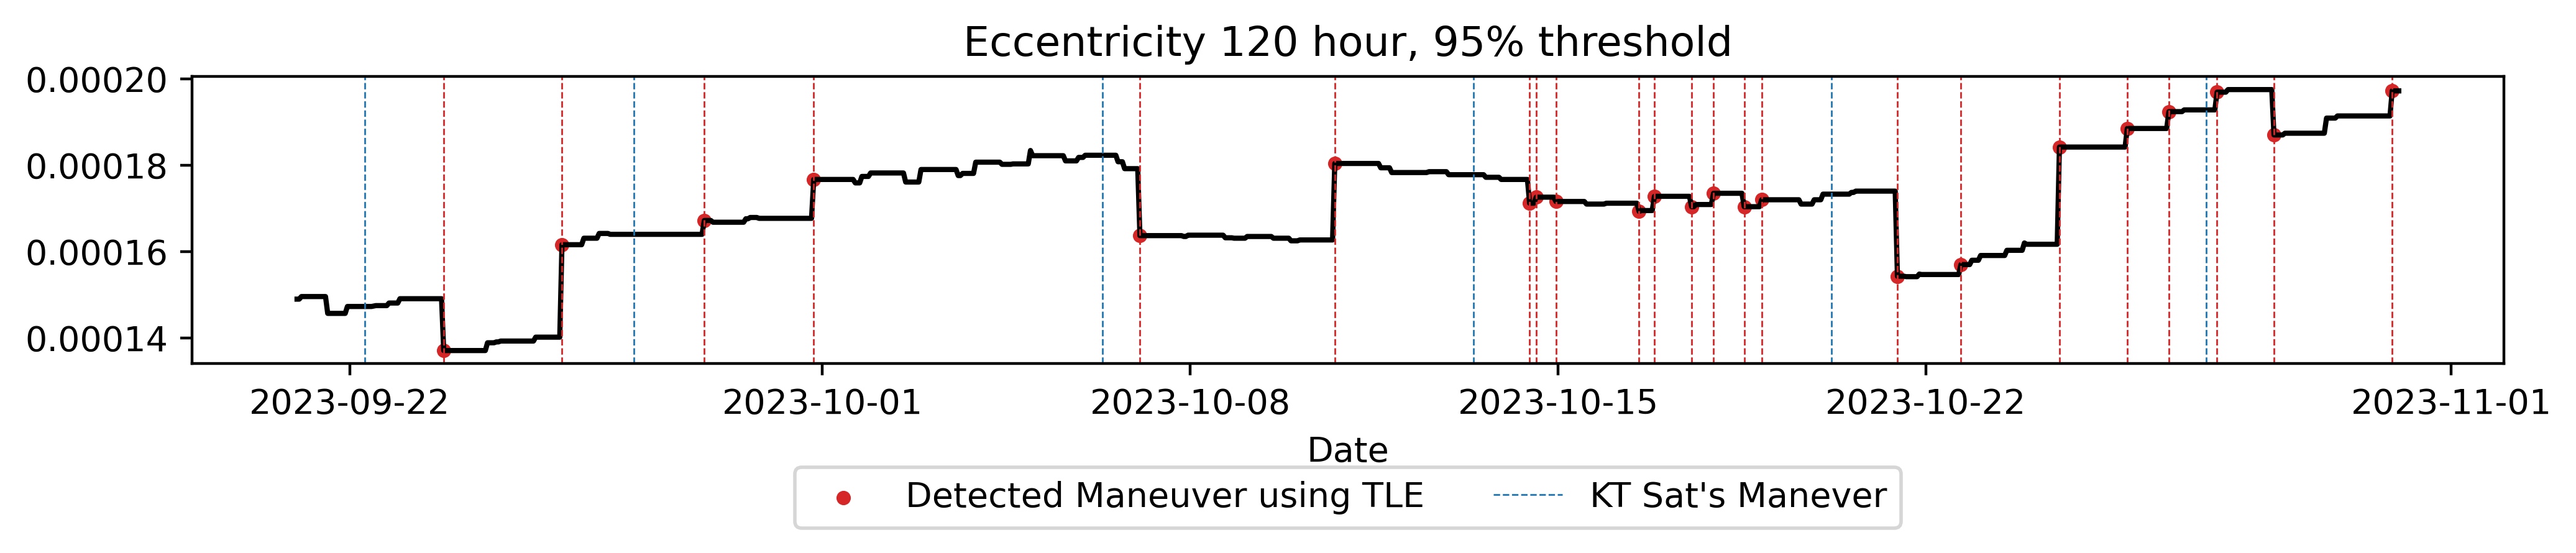

window : 240, level : 95


100%|██████████| 13633/13633 [00:03<00:00, 4124.67it/s]


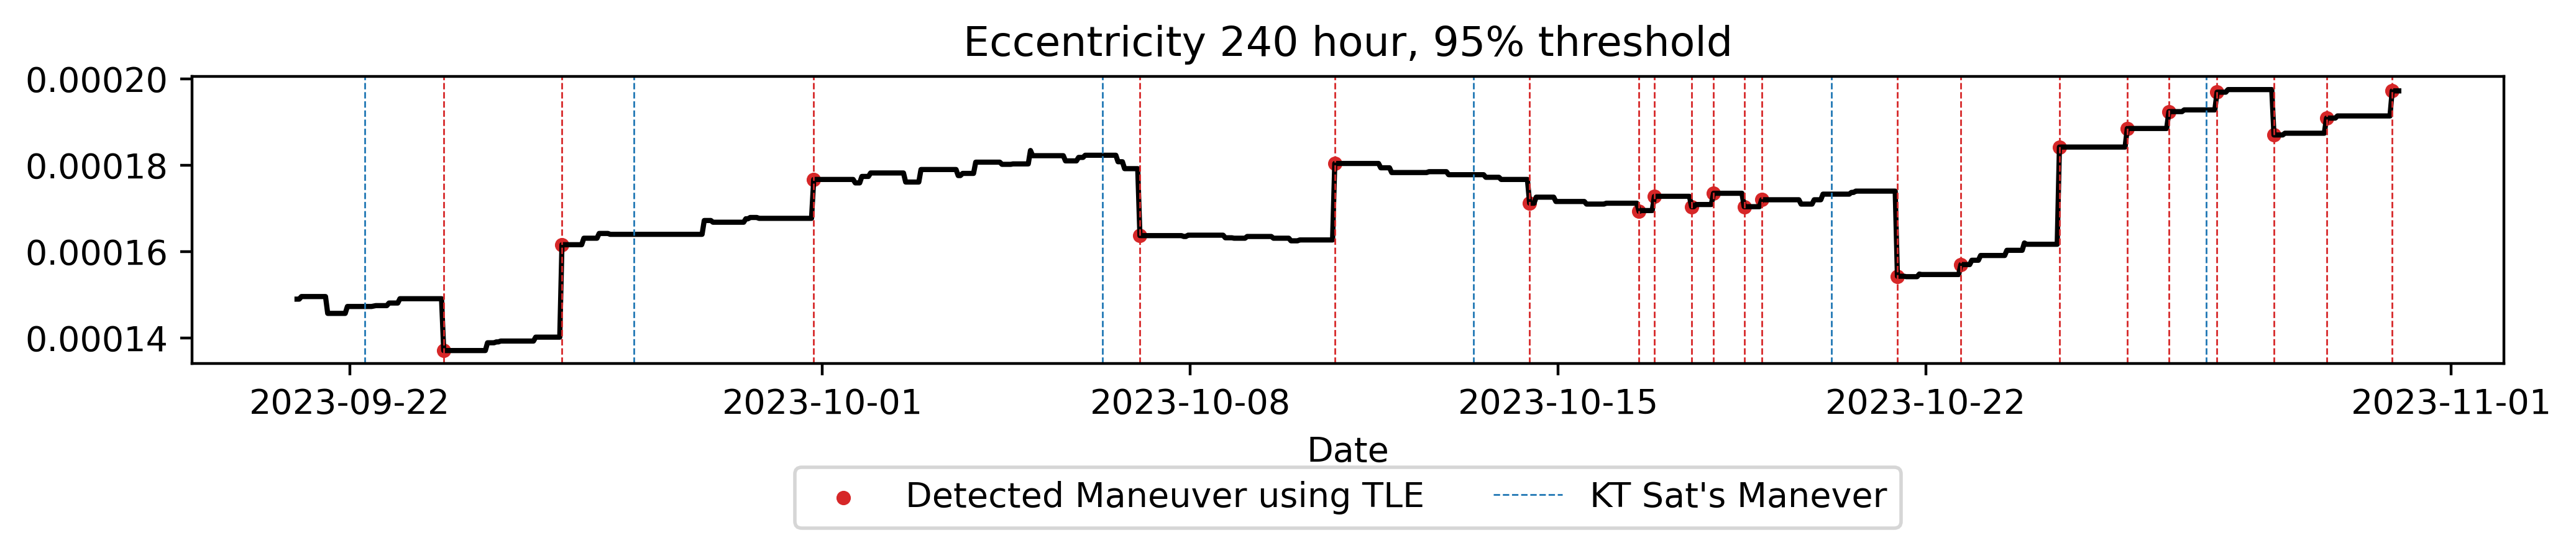

window : 120, level : 99


100%|██████████| 13753/13753 [00:03<00:00, 4109.84it/s]


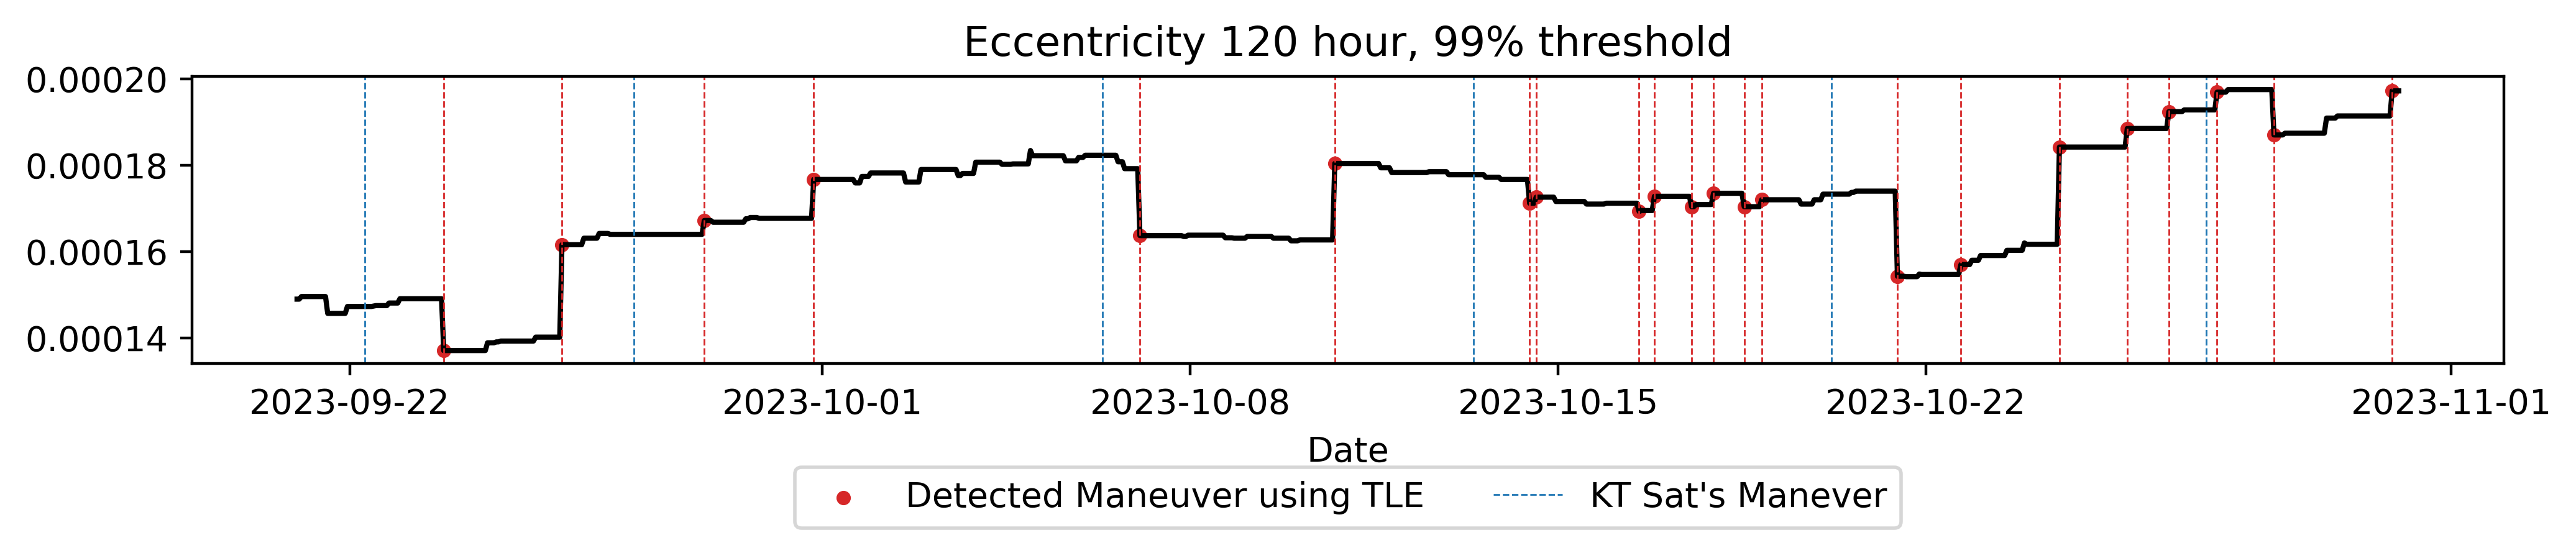

window : 240, level : 99


100%|██████████| 13633/13633 [00:03<00:00, 4141.45it/s]


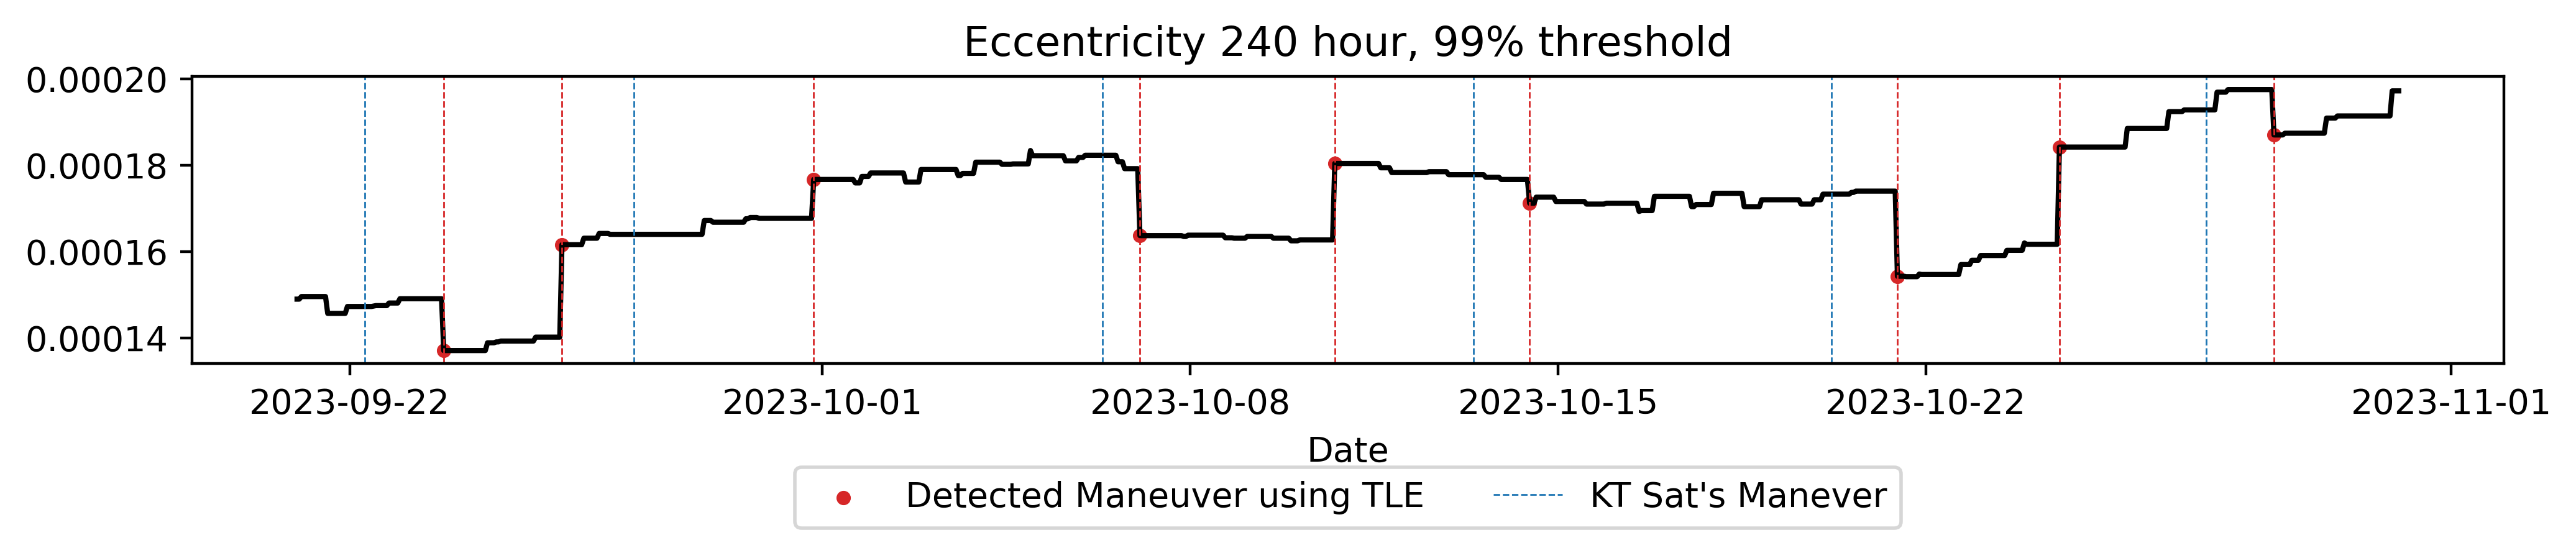

window : 120, level : 95


100%|██████████| 13753/13753 [00:03<00:00, 3987.41it/s]


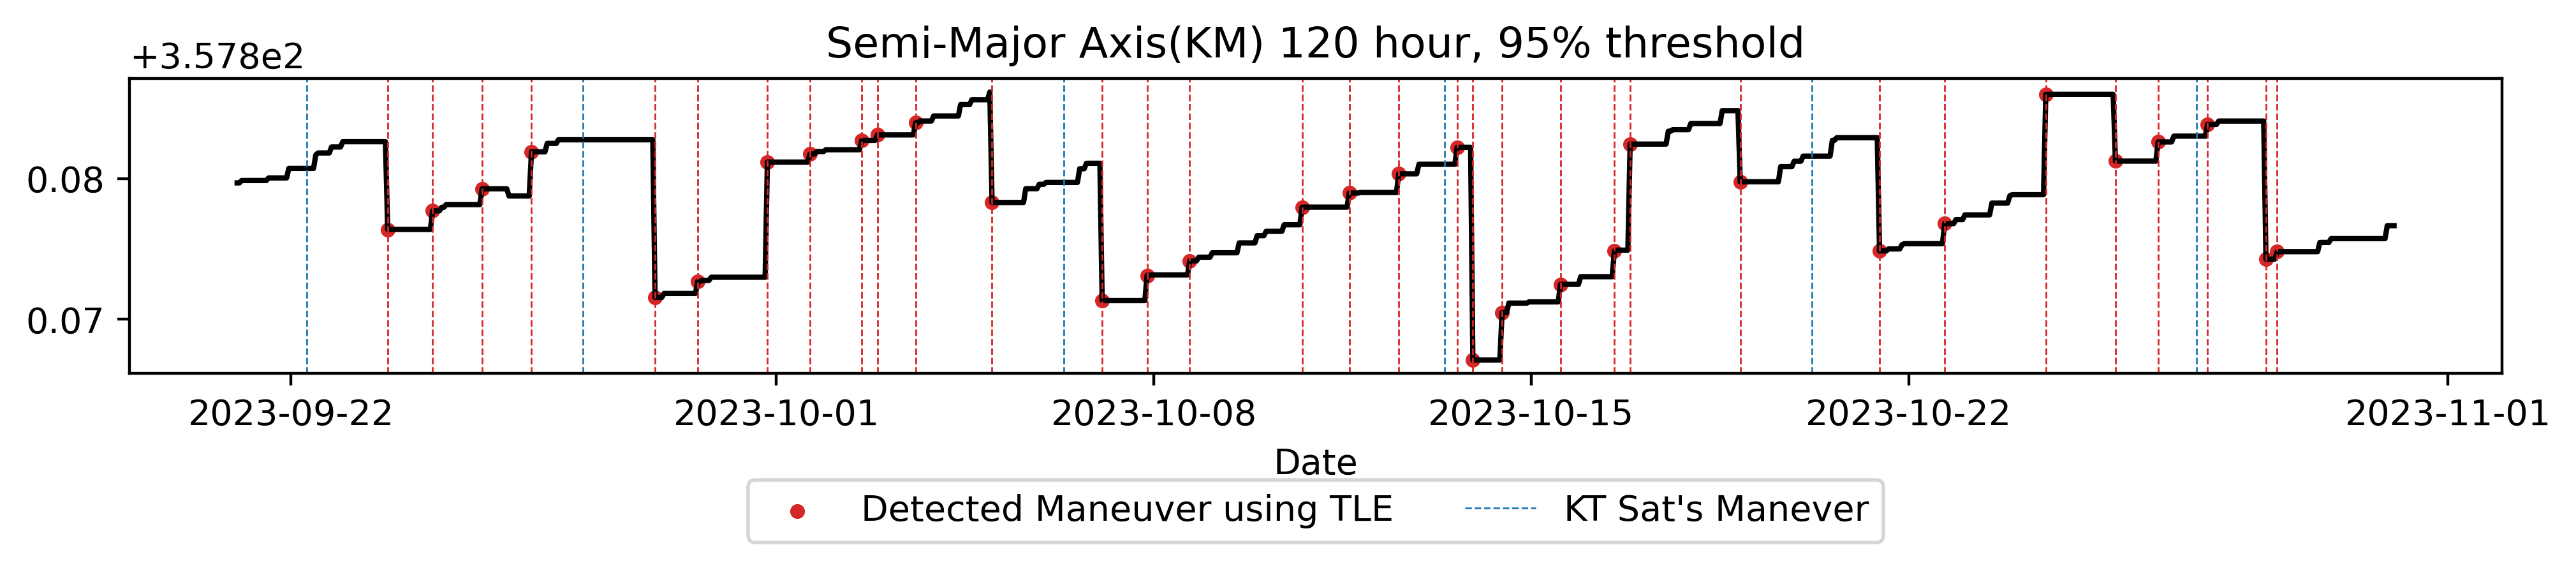

window : 240, level : 95


100%|██████████| 13633/13633 [00:03<00:00, 4160.34it/s]


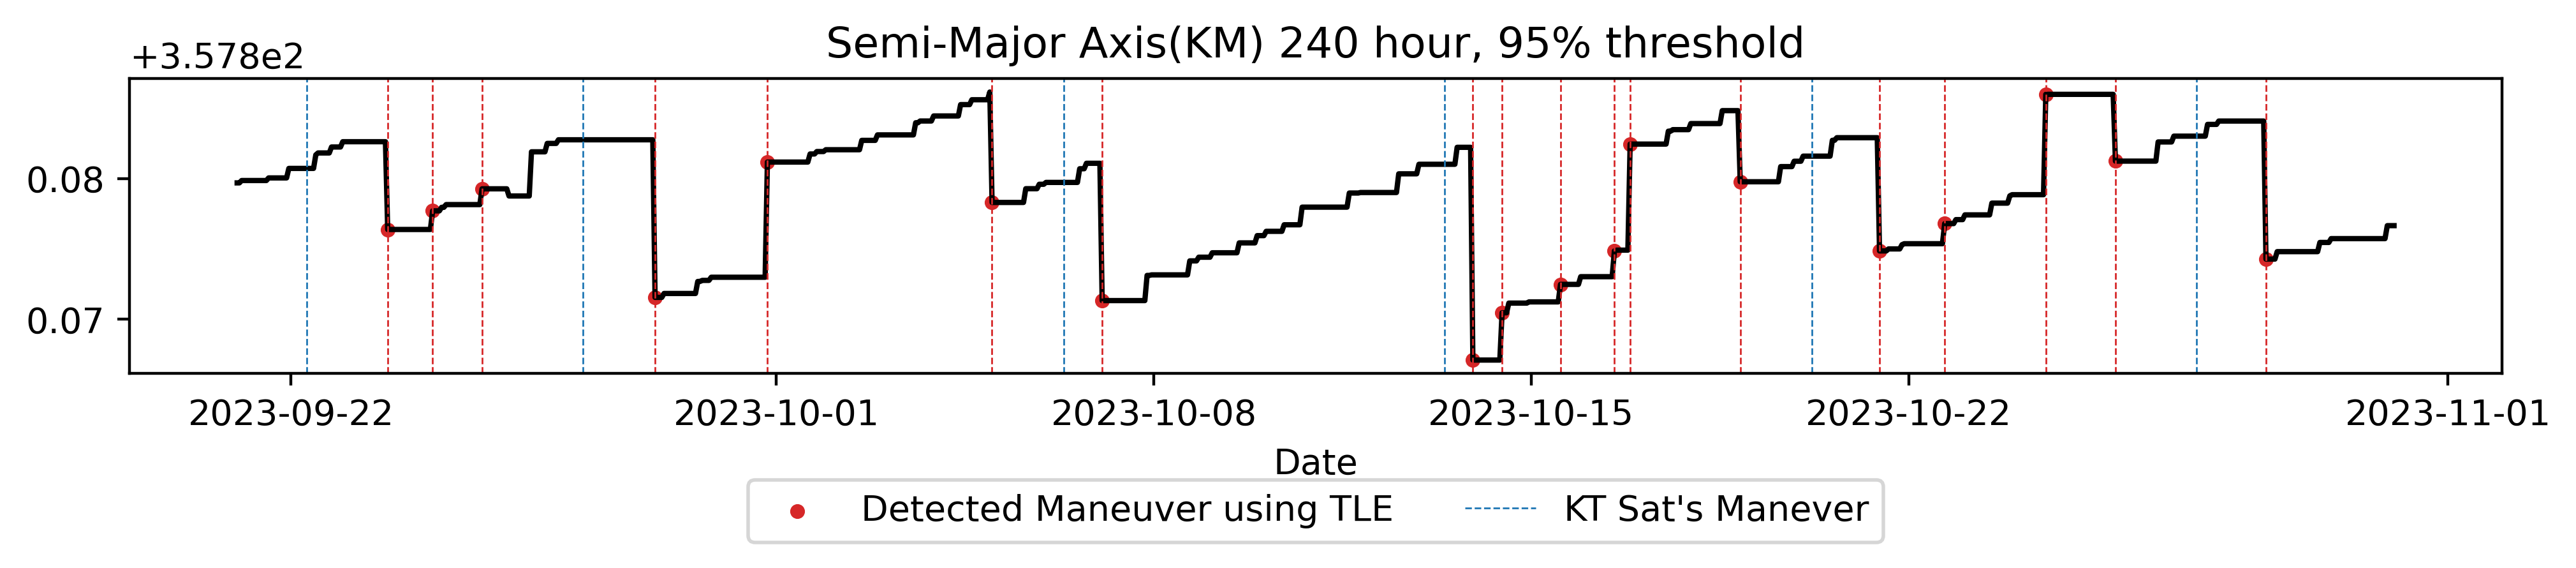

window : 120, level : 99


100%|██████████| 13753/13753 [00:03<00:00, 4055.55it/s]


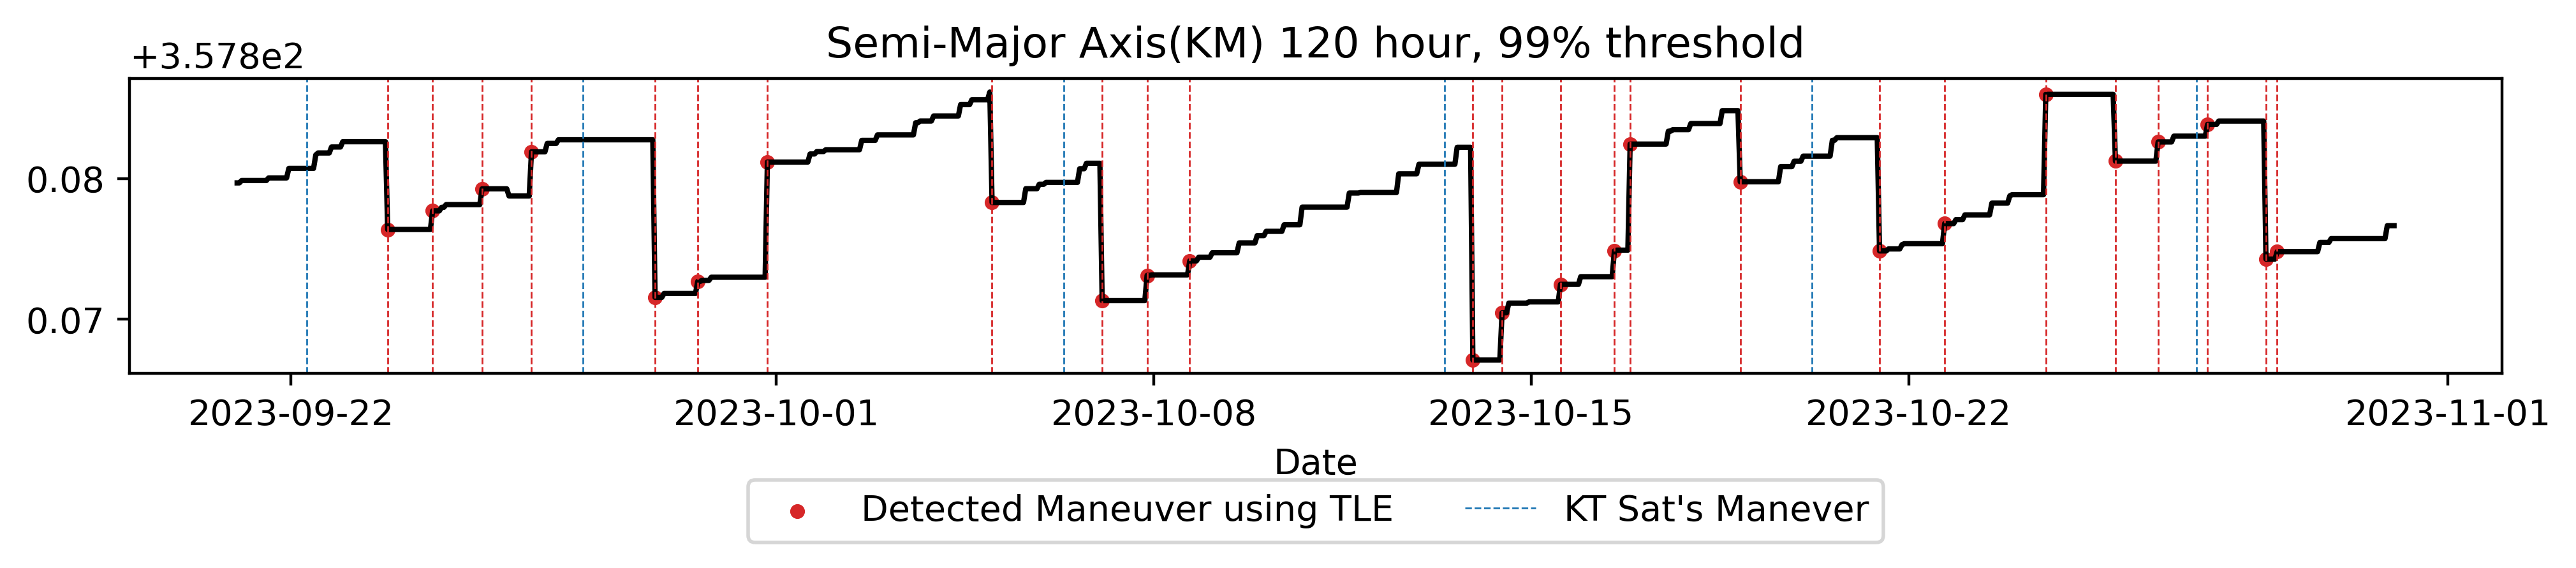

window : 240, level : 99


100%|██████████| 13633/13633 [00:03<00:00, 4166.06it/s]


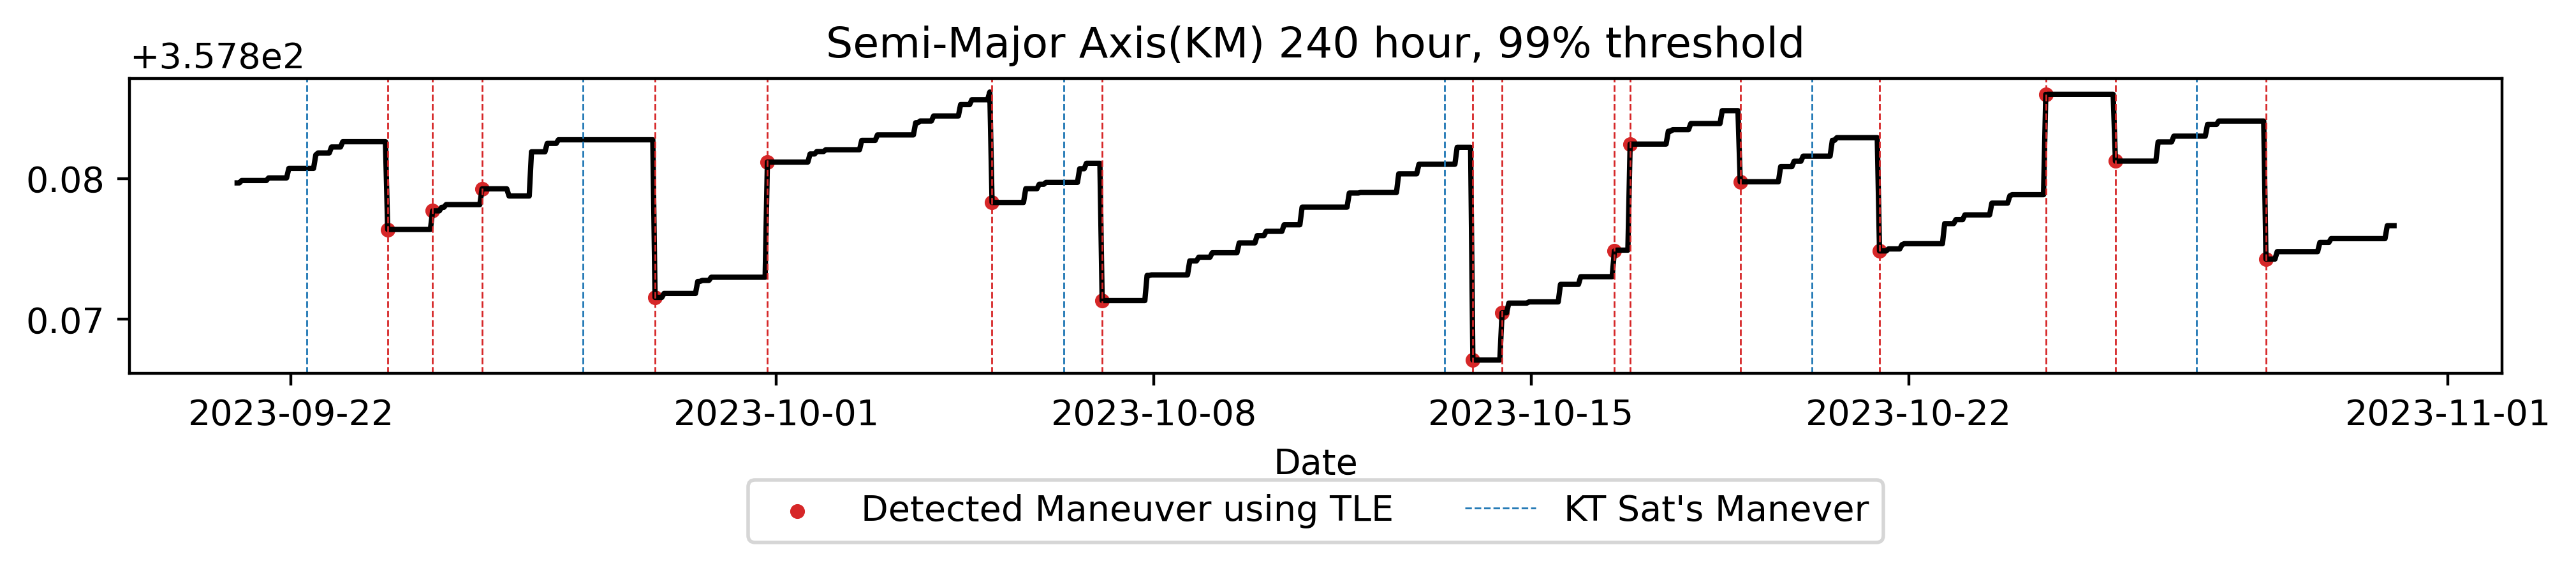

In [32]:

col_name = 'Eccentricity'
# col_name = 'inclination'

if col_name == 'Eccentricity':
    safran_data = safran_df[np.abs(safran_df['dz'])<1]
    kt_data = pd.to_datetime(kt_data_lon)
else:
    safran_data = safran_df[np.abs(safran_df['dz'])>=1]
    kt_data = pd.to_datetime(kt_data_inclination)

value = hour_df[col_name].values
diff_value = np.log(hour_df[col_name]).diff().fillna(0).values
 
for level in [95,99]:
    for window in [24*5,24*10]:
        temp = [col_name,level,window,'ON']
        print(f'window : {window}, level : {level}')
        temp.extend(ol_detect_2024_KT(hour_df, diff_value, window, level,col_name,safran_data,kt_data,'','ON'))
        ol_all_infos.append(temp)

col_name = 'Semi-Major Axis(KM)'
# col_name = 'raan'

if col_name == 'Semi-Major Axis(KM)':
    safran_data = safran_df[np.abs(safran_df['dz'])<1]
    kt_data = pd.to_datetime(kt_data_lon)
else:
    safran_data = safran_df[np.abs(safran_df['dz'])>=1]
    kt_data = pd.to_datetime(kt_data_inclination)

value = hour_df[col_name].values
diff_value = np.log(hour_df[col_name]).diff().fillna(0).values
 
for level in [95,99]:
    for window in [24*5,24*10]:
        temp = [col_name,level,window,'ON']
        print(f'window : {window}, level : {level}')
        temp.extend(ol_detect_2024_KT(hour_df, diff_value, window, level,col_name,safran_data,kt_data,'','ON'))
        ol_all_infos.append(temp)
        
        

In [33]:
temp_df = pd.DataFrame(ol_all_infos).astype('str')

4     2023-09-23 19:00:00
5     2023-09-26 01:00:00
6     2023-09-28 18:00:00
7     2023-09-30 20:00:00
8     2023-10-07 01:00:00
9     2023-10-10 18:00:00
10    2023-10-14 11:00:00
11    2023-10-14 14:00:00
12    2023-10-14 23:00:00
13    2023-10-16 13:00:00
14    2023-10-16 20:00:00
15    2023-10-17 13:00:00
16    2023-10-17 23:00:00
17    2023-10-18 13:00:00
18    2023-10-18 21:00:00
19    2023-10-21 11:00:00
20    2023-10-22 16:00:00
21    2023-10-24 13:00:00
22    2023-10-25 20:00:00
23    2023-10-26 15:00:00
24    2023-10-27 13:00:00
25    2023-10-28 15:00:00
26    2023-10-30 21:00:00
27                    NaT
28                    NaT
29                    NaT
30                    NaT
31                    NaT
32                    NaT
33                    NaT
34                    NaT
35                    NaT
36                    NaT
Name: 0, dtype: object
4     2023-09-23 19:00:00
5     2023-09-24 15:00:00
6     2023-09-25 13:00:00
7     2023-09-26 11:00:00
8     2023-09-2

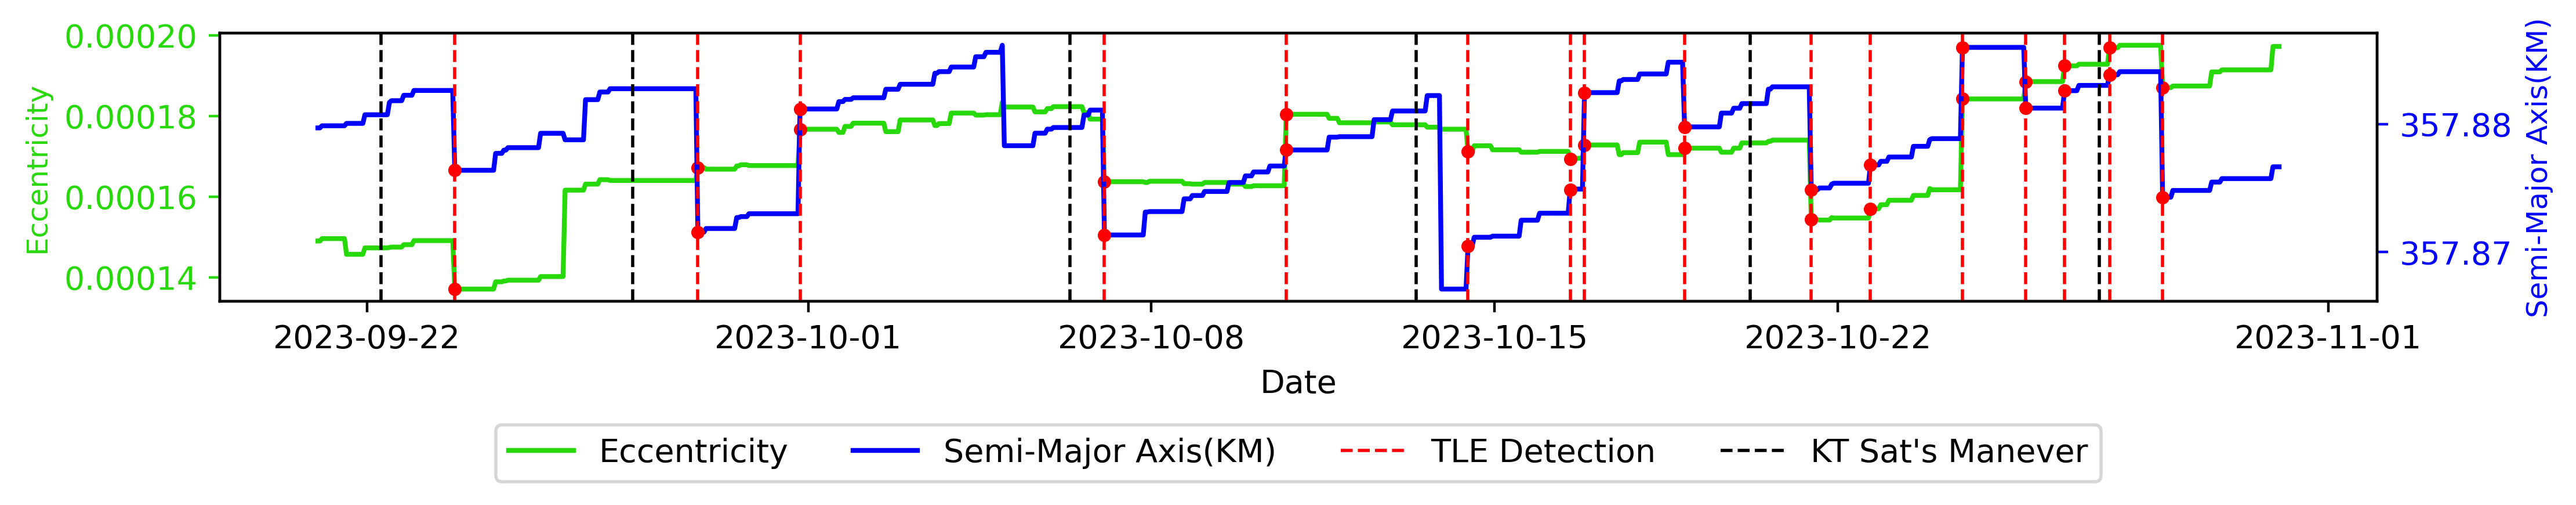

4     2023-09-23 19:00:00
5     2023-09-26 01:00:00
6     2023-09-30 20:00:00
7     2023-10-07 01:00:00
8     2023-10-10 18:00:00
9     2023-10-14 11:00:00
10    2023-10-16 13:00:00
11    2023-10-16 20:00:00
12    2023-10-17 13:00:00
13    2023-10-17 23:00:00
14    2023-10-18 13:00:00
15    2023-10-18 21:00:00
16    2023-10-21 11:00:00
17    2023-10-22 16:00:00
18    2023-10-24 13:00:00
19    2023-10-25 20:00:00
20    2023-10-26 15:00:00
21    2023-10-27 13:00:00
22    2023-10-28 15:00:00
23    2023-10-29 15:00:00
24    2023-10-30 21:00:00
25                    NaT
26                    NaT
27                    NaT
28                    NaT
29                    NaT
30                    NaT
31                    NaT
32                    NaT
33                    NaT
34                    NaT
35                    NaT
36                    NaT
Name: 1, dtype: object
4     2023-09-23 19:00:00
5     2023-09-24 15:00:00
6     2023-09-25 13:00:00
7     2023-09-28 18:00:00
8     2023-09-3

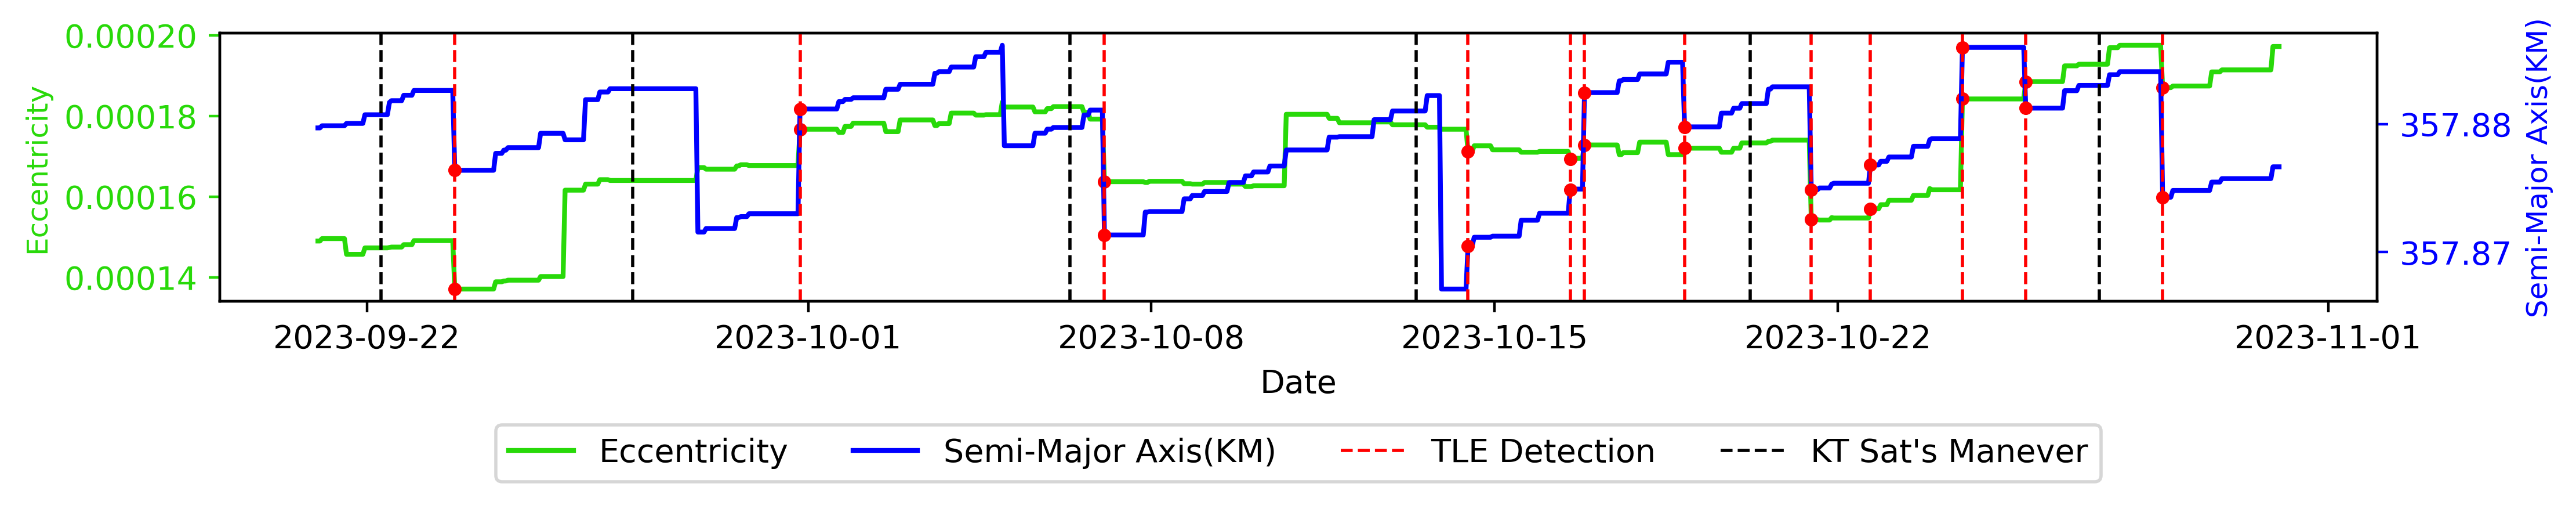

4     2023-09-23 19:00:00
5     2023-09-26 01:00:00
6     2023-09-28 18:00:00
7     2023-09-30 20:00:00
8     2023-10-07 01:00:00
9     2023-10-10 18:00:00
10    2023-10-14 11:00:00
11    2023-10-14 14:00:00
12    2023-10-16 13:00:00
13    2023-10-16 20:00:00
14    2023-10-17 13:00:00
15    2023-10-17 23:00:00
16    2023-10-18 13:00:00
17    2023-10-18 21:00:00
18    2023-10-21 11:00:00
19    2023-10-22 16:00:00
20    2023-10-24 13:00:00
21    2023-10-25 20:00:00
22    2023-10-26 15:00:00
23    2023-10-27 13:00:00
24    2023-10-28 15:00:00
25    2023-10-30 21:00:00
26                    NaT
27                    NaT
28                    NaT
29                    NaT
30                    NaT
31                    NaT
32                    NaT
33                    NaT
34                    NaT
35                    NaT
36                    NaT
Name: 2, dtype: object
4     2023-09-23 19:00:00
5     2023-09-24 15:00:00
6     2023-09-25 13:00:00
7     2023-09-26 11:00:00
8     2023-09-2

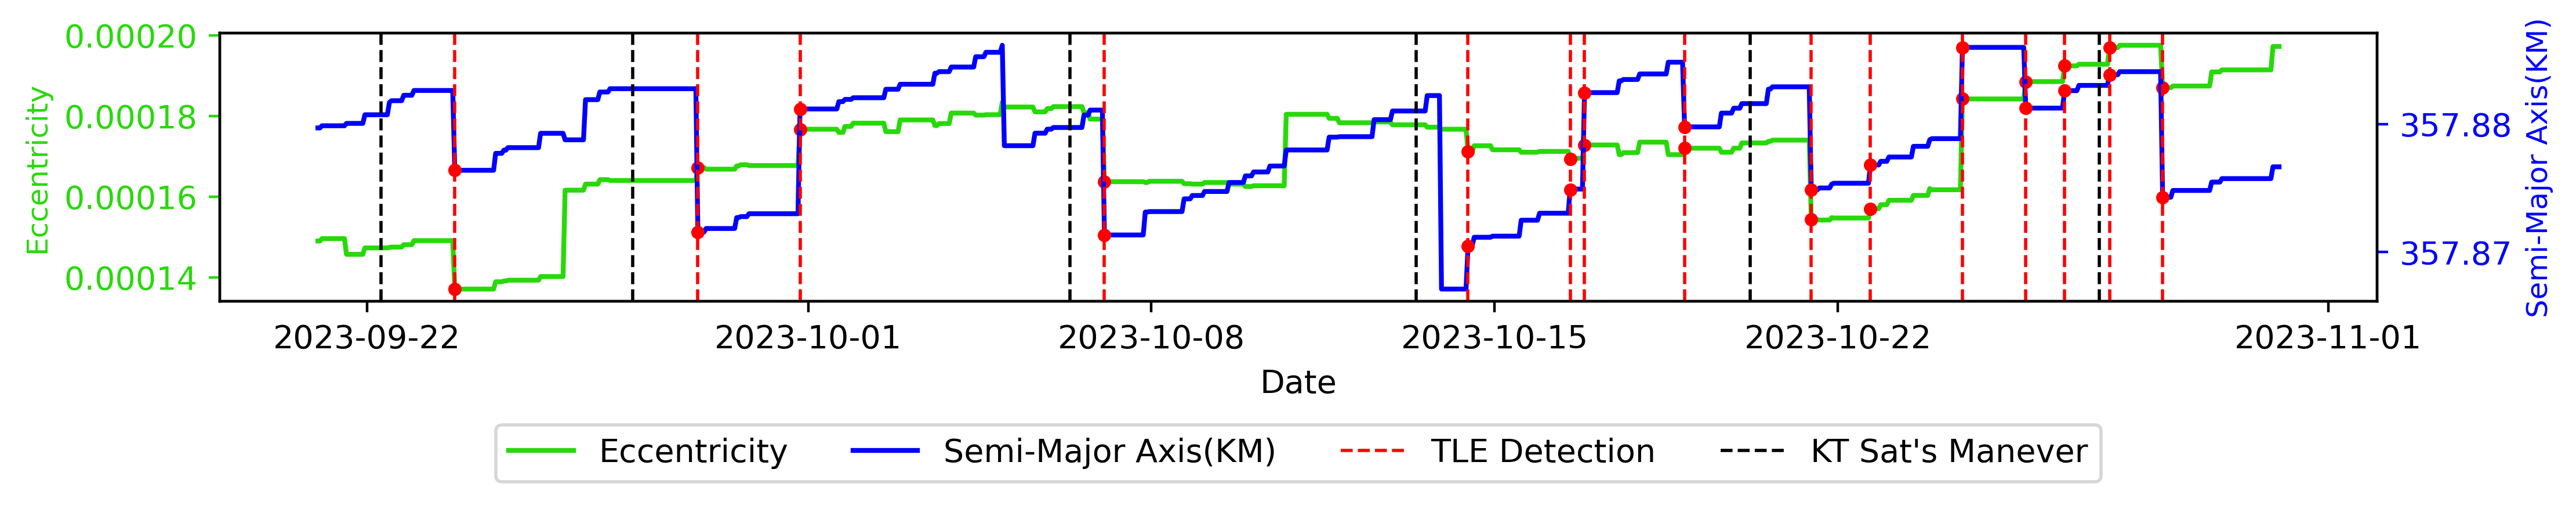

4     2023-09-23 19:00:00
5     2023-09-26 01:00:00
6     2023-09-30 20:00:00
7     2023-10-07 01:00:00
8     2023-10-10 18:00:00
9     2023-10-14 11:00:00
10    2023-10-21 11:00:00
11    2023-10-24 13:00:00
12    2023-10-28 15:00:00
13                    NaT
14                    NaT
15                    NaT
16                    NaT
17                    NaT
18                    NaT
19                    NaT
20                    NaT
21                    NaT
22                    NaT
23                    NaT
24                    NaT
25                    NaT
26                    NaT
27                    NaT
28                    NaT
29                    NaT
30                    NaT
31                    NaT
32                    NaT
33                    NaT
34                    NaT
35                    NaT
36                    NaT
Name: 3, dtype: object
4     2023-09-23 19:00:00
5     2023-09-24 15:00:00
6     2023-09-25 13:00:00
7     2023-09-28 18:00:00
8     2023-09-3

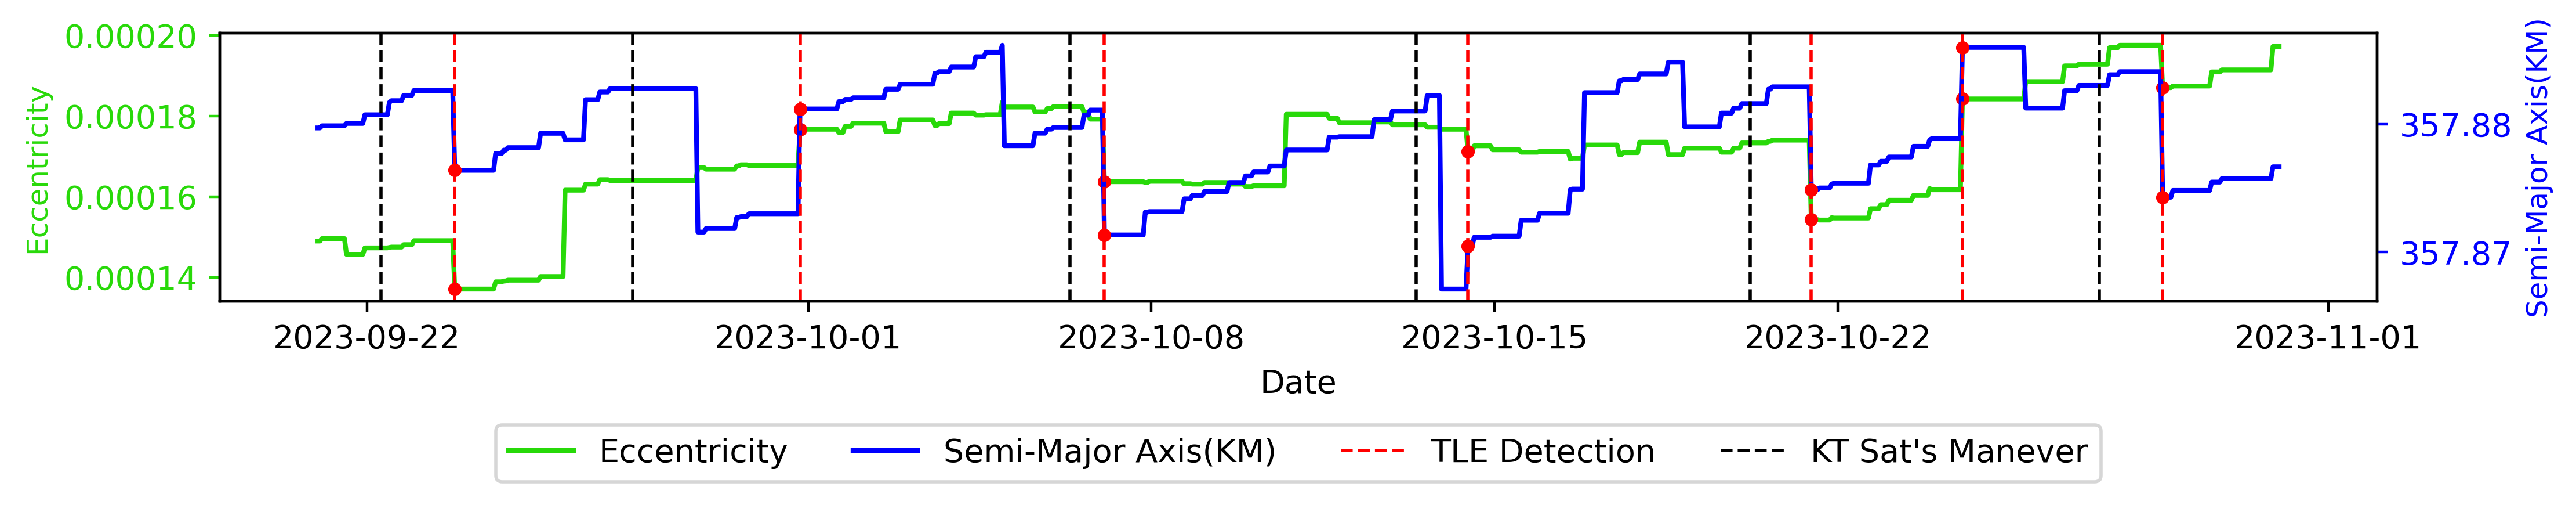

In [34]:
for i in range(4):
    eccen_lst = temp_df.iloc[i][4:]
    Sma_lst = temp_df.iloc[i+4][4:]
    print(eccen_lst)
    print(Sma_lst)
    co_ol_lst = [pd.to_datetime(ol) for ol in list(set(eccen_lst) & set(Sma_lst)) if ol !='NaT']
    co_ol_lst.sort()


    # Figure와 첫 번째 y축 생성
    fig, ax1 = plt.subplots(figsize=(12, 1.5), dpi=400)

    # 첫 번째 데이터 플롯
    ax1.plot(hour_df[temp_df.iloc[i][0]][(pd.to_datetime('2023-09-21')<=hour_df[temp_df.iloc[i][0]].index) & (hour_df[temp_df.iloc[i][0]].index<=pd.to_datetime('2023-10-31'))], color=(40/255, 217/255, 9/255),label = temp_df.iloc[i][0])
    ax1.set_xlabel('Date')
    ax1.set_ylabel(temp_df.iloc[i][0], fontsize=9, color=(40/255, 217/255, 9/255))

    # ax1.spines['left'].set_color((0, 0, 1))  # 왼쪽 y축 색깔 변경
    ax1.tick_params(axis='y', colors=(40/255, 217/255, 9/255))

    # 두 번째 y축 생성
    ax2 = ax1.twinx()
    ax2.plot(hour_df[temp_df.iloc[i+4][0]][(pd.to_datetime('2023-09-21')<=hour_df[temp_df.iloc[i+4][0]].index) & (hour_df[temp_df.iloc[i+4][0]].index<=pd.to_datetime('2023-10-31'))], color=(0, 0, 1),label = temp_df.iloc[i+4][0])
    ax2.set_ylabel(temp_df.iloc[i+4][0], fontsize=9, color=(0, 0, 1))

    # ax2.spines['right'].set_color((1, 0, 0))  # 오른쪽 y축 색깔 변경
    ax2.tick_params(axis='y', colors=(0, 0, 1))
    
    formatter = ticker.ScalarFormatter(useOffset=False)
    ax2.yaxis.set_major_formatter(formatter)
    # ax2.get_yaxis().get_major_formatter().set_useOffset(True)
    # y축 범위를 설정할 때 올바른 메서드 호출 방식
    # ax2.set_ylim(hour_df['SMA (Semi-Major Axis)(KM)'].mean() - 0.000001,
    #              hour_df['SMA (Semi-Major Axis)(KM)'].mean() + 0.000001)


    # # PLOT 함수
    # plt.figure(figsize=(12,1.5),dpi=400)
    # plt.plot(hour_df[temp_df.iloc[i][0]][(pd.to_datetime('2023-09-21')<=hour_df[temp_df.iloc[i][0]].index) & (hour_df[temp_df.iloc[i][0]].index<=pd.to_datetime('2023-10-31'))],color='black')
    # plt.plot(hour_df[temp_df.iloc[i+4][0]][(pd.to_datetime('2023-09-21')<=hour_df[temp_df.iloc[i+4][0]].index) & (hour_df[temp_df.iloc[i+4][0]].index<=pd.to_datetime('2023-10-31'))],color='black')

    # Y 축 범위 설정 ----------------------------------------------------------------------------------------------------------------------------------
    # plt.ylim(hour_df[col_name].mean() - 0.02 , hour_df[col_name].mean() +0.02)

    for point in co_ol_lst:
        if (pd.to_datetime('2023-09-21')<=point) & (point<=pd.to_datetime('2023-10-31')):
            # print('ICSS-----' + str(hour_df.index[point]))
            plt.axvline(point, color=(1,0,0), linewidth=1, linestyle='--',label = "TLE Detection")
            ax1.scatter(point, hour_df['Eccentricity'].loc[point], color=(1,0,0), s=10,zorder=5)
            ax2.scatter(point, hour_df['Semi-Major Axis(KM)'].loc[point], color=(1,0,0), s=10,zorder=5)

            # 사프란 선 긋기 ----------------------------------------------------------------------------------------------------------------------------------

    # for time in safran_df.index:
    #     if (pd.to_datetime('2023-09-21')<=time) & (time<=pd.to_datetime('2023-10-31')):
    #         # print('safran-----' + str(time))
    #         plt.axvline(time, color='tab:green', linewidth=0.5, linestyle='--',label = "Safran Observed Maneuver")

    # 사프란 선 긋기 ----------------------------------------------------------------------------------------------------------------------------------
    for time in kt_data:
        if (pd.to_datetime('2023-09-21')<=time) & (time<=pd.to_datetime('2023-10-31')):
            # print('safran-----' + str(time))
            plt.axvline(time, color=(0,0,0), linewidth=1, linestyle='--',label = "KT Sat's Manever")

    # plt.title(list(temp_df.iloc[i][1:4])[0] + '% threshold, ' +list(temp_df.iloc[i][1:4])[1] + 'hours')
    plt.xlabel('Date')

    # 각 축에서 범례 항목들을 수집하고 중복 제거
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()

    handles = handles1 + handles2
    labels = labels1 + labels2

    by_label = dict(zip(labels, handles))

    # 중복 제거된 범례를 표시
    plt.legend(by_label.values(), by_label.keys(),loc='upper center', ncol=4, bbox_to_anchor=(0.5, -0.4))
    #plt.legend()
    plt.show()

In [35]:
# temp_df = pd.DataFrame(ol_all_infos).astype('str')
# 
# for i in range(4):
#     eccen_lst = temp_df.iloc[i][4:]
#     Sma_lst = temp_df.iloc[i+4][4:]
#     co_ol_lst = [pd.to_datetime(ol) for ol in list(set(eccen_lst) & set(Sma_lst)) if ol !='NaT']
#     co_ol_lst.sort()
# 
# 
#     # Figure와 첫 번째 y축 생성
#     fig, ax1 = plt.subplots(figsize=(12, 1.5), dpi=400)
# 
#     # 첫 번째 데이터 플롯
#     ax1.plot(hour_df[temp_df.iloc[i][0]][(pd.to_datetime('2023-09-21')<=hour_df[temp_df.iloc[i][0]].index) & (hour_df[temp_df.iloc[i][0]].index<=pd.to_datetime('2023-10-31'))], color='black',label = temp_df.iloc[i][0])
#     ax1.set_xlabel('Date')
#     ax1.set_ylabel(temp_df.iloc[i][0], color='black')
#     
#     # 두 번째 y축 생성
#     ax2 = ax1.twinx()
#     ax2.plot(hour_df[temp_df.iloc[i+4][0]][(pd.to_datetime('2023-09-21')<=hour_df[temp_df.iloc[i+4][0]].index) & (hour_df[temp_df.iloc[i+4][0]].index<=pd.to_datetime('2023-10-31'))], color='gray',label = temp_df.iloc[i+4][0])
#     ax2.set_ylabel(temp_df.iloc[i+4][0], color='gray')
# 
#     # # PLOT 함수
#     # plt.figure(figsize=(12,1.5),dpi=400)
#     # plt.plot(hour_df[temp_df.iloc[i][0]][(pd.to_datetime('2023-09-21')<=hour_df[temp_df.iloc[i][0]].index) & (hour_df[temp_df.iloc[i][0]].index<=pd.to_datetime('2023-10-31'))],color='black')
#     # plt.plot(hour_df[temp_df.iloc[i+4][0]][(pd.to_datetime('2023-09-21')<=hour_df[temp_df.iloc[i+4][0]].index) & (hour_df[temp_df.iloc[i+4][0]].index<=pd.to_datetime('2023-10-31'))],color='black')
#         
#     # Y 축 범위 설정 ----------------------------------------------------------------------------------------------------------------------------------
#     # plt.ylim(hour_df[col_name].mean() - 0.02 , hour_df[col_name].mean() +0.02)
# 
#     for point in co_ol_lst:
#         if (pd.to_datetime('2023-09-21')<=point) & (point<=pd.to_datetime('2023-10-31')):
#             # print('ICSS-----' + str(hour_df.index[point]))
#             plt.axvline(point, color='tab:red', linewidth=0.5, linestyle='--')
#             plt.scatter(point, hour_df[col_name].loc[point], color='tab:red', s=10,label = 'Detected Maneuver using TLE')
# 
#     # 사프란 선 긋기 ----------------------------------------------------------------------------------------------------------------------------------
#     
#     # for time in safran_df.index:
#     #     if (pd.to_datetime('2023-09-21')<=time) & (time<=pd.to_datetime('2023-10-31')):
#     #         # print('safran-----' + str(time))
#     #         plt.axvline(time, color='tab:green', linewidth=0.5, linestyle='--',label = "Safran Observed Maneuver")
# 
#     # 사프란 선 긋기 ----------------------------------------------------------------------------------------------------------------------------------
#     for time in kt_data:
#         if (pd.to_datetime('2023-09-21')<=time) & (time<=pd.to_datetime('2023-10-31')):
#             # print('safran-----' + str(time))
#             plt.axvline(time, color='tab:blue', linewidth=0.5, linestyle='--',label = "KT Sat's Manever")
#     
#     plt.title(list(temp_df.iloc[i][1:4])[0] + '% threshold, ' +list(temp_df.iloc[i][1:4])[1] + 'hours')
#     plt.xlabel('Date')
# 
#     # 각 축에서 범례 항목들을 수집하고 중복 제거
#     handles1, labels1 = ax1.get_legend_handles_labels()
#     handles2, labels2 = ax2.get_legend_handles_labels()
# 
#     handles = handles1 + handles2
#     labels = labels1 + labels2
# 
#     by_label = dict(zip(labels, handles))
# 
#     # 중복 제거된 범례를 표시
#     plt.legend(by_label.values(), by_label.keys(),loc='upper center', ncol=4, bbox_to_anchor=(0.5, -0.3))
#     #plt.legend()
#     plt.show()  

In [36]:
ol_all_infos2 = []

window : 120, level : 95


100%|██████████| 13753/13753 [00:03<00:00, 4013.17it/s]


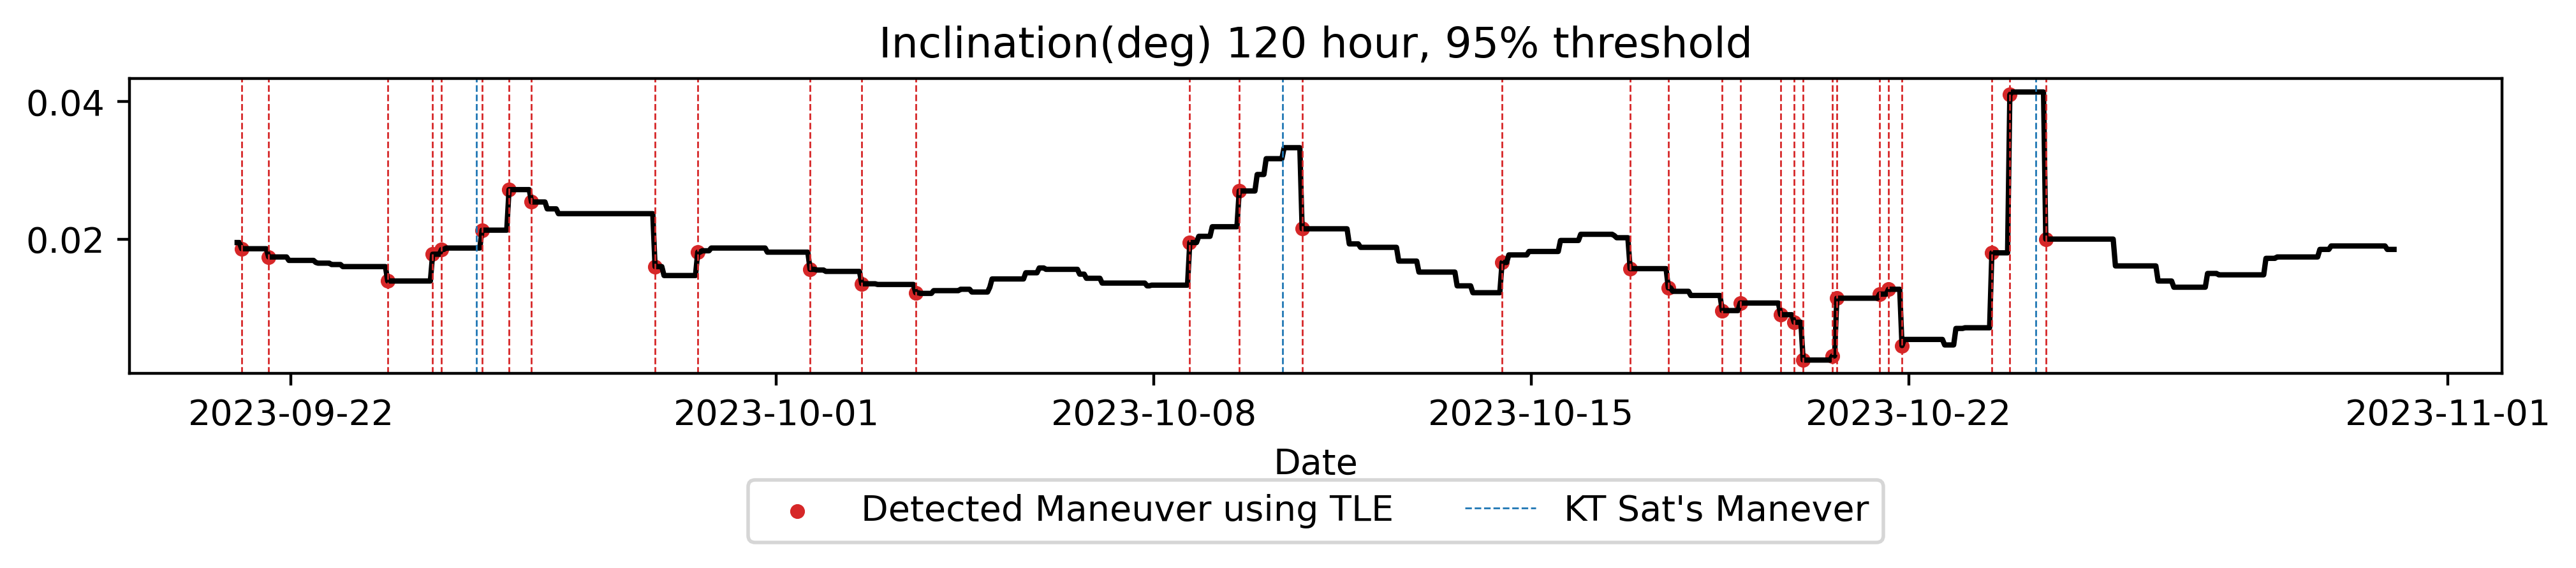

window : 240, level : 95


100%|██████████| 13633/13633 [00:03<00:00, 4166.82it/s]


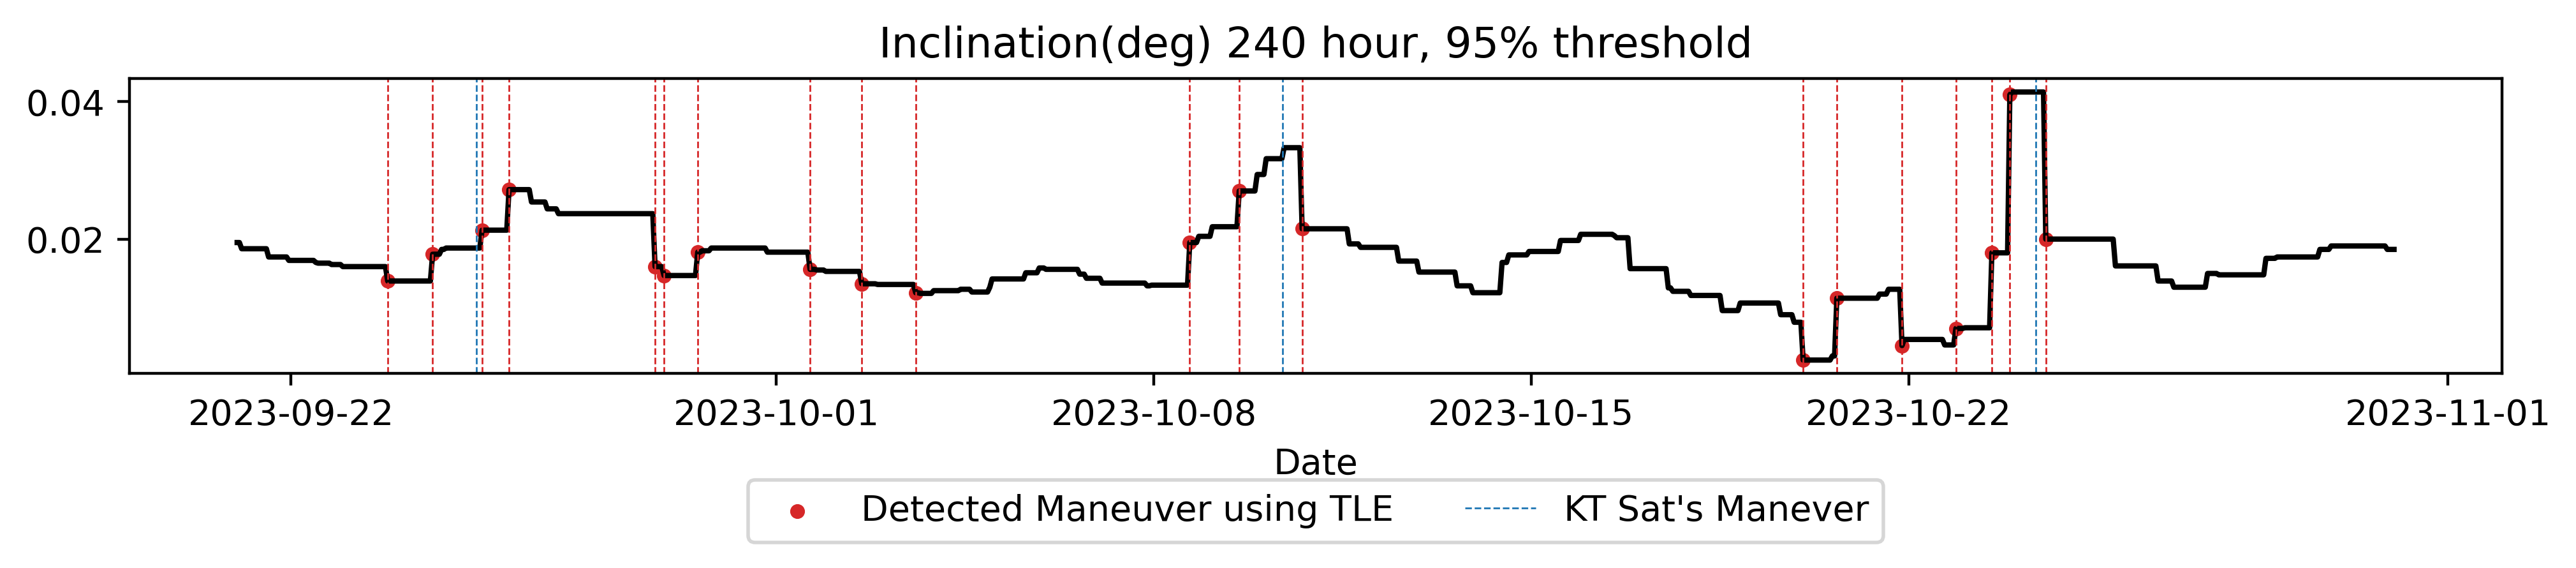

window : 120, level : 99


100%|██████████| 13753/13753 [00:03<00:00, 4142.46it/s]


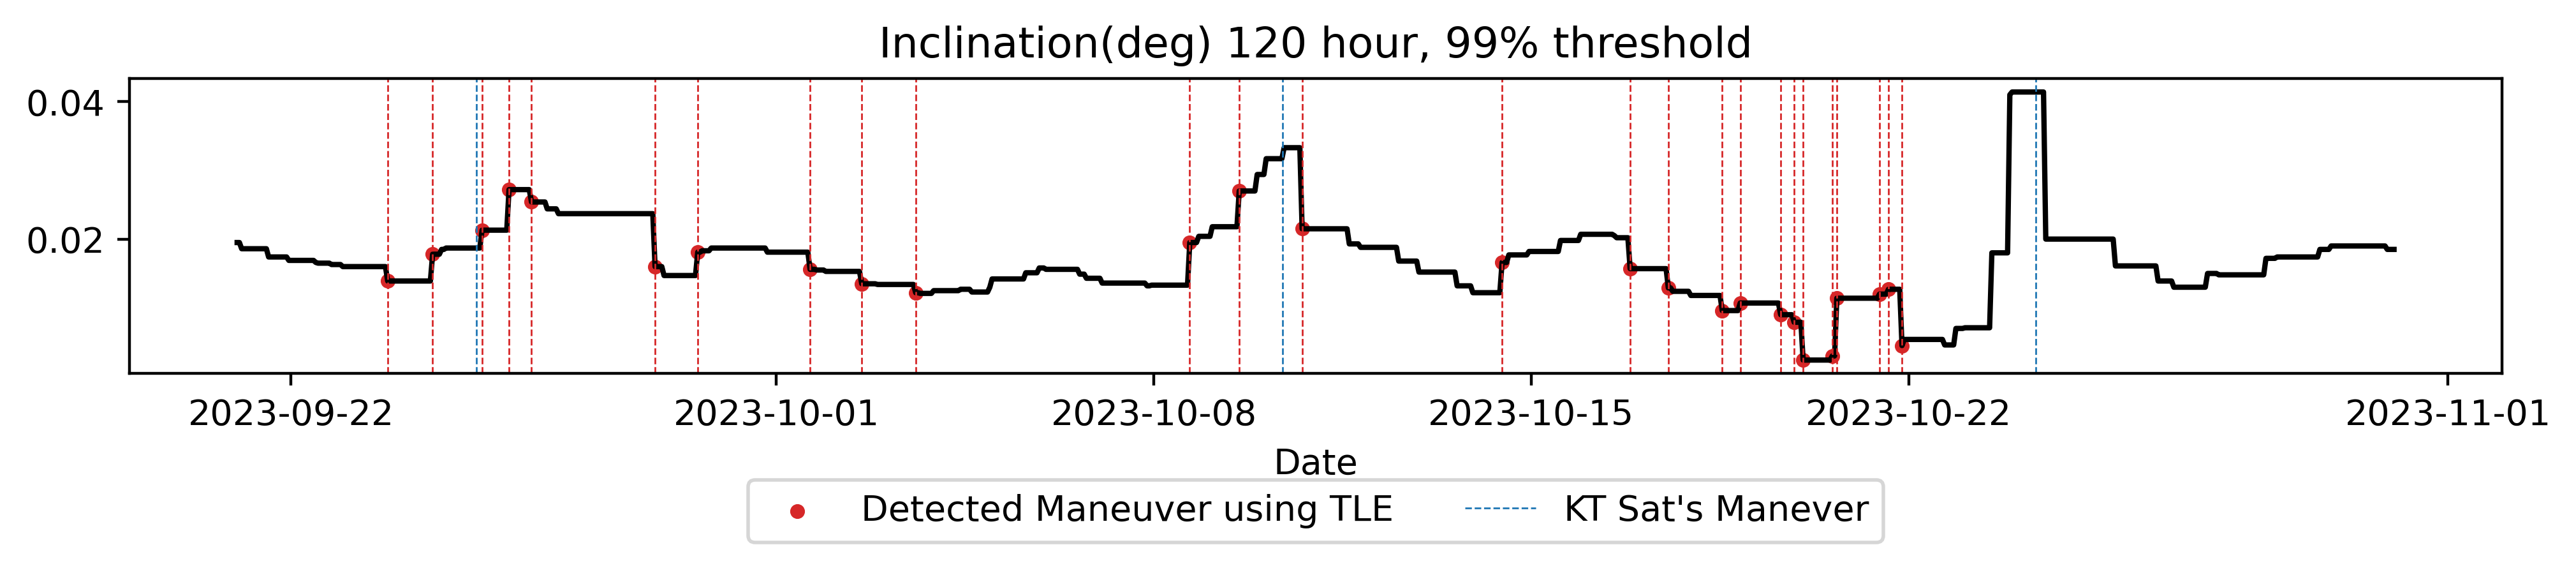

window : 240, level : 99


  1%|          | 91/13633 [00:00<00:03, 4419.35it/s]

KeyboardInterrupt



In [37]:

col_name = 'Inclination(deg)'

if col_name == 'Eccentricity':
    safran_data = safran_df[np.abs(safran_df['dz'])<1]
    kt_data = pd.to_datetime(kt_data_lon)
else:
    safran_data = safran_df[np.abs(safran_df['dz'])>=1]
    kt_data = pd.to_datetime(kt_data_inclination)

value = hour_df[col_name].values
diff_value = np.log(hour_df[col_name]).diff().fillna(0).values
 
for level in [95,99]:
    for window in [24*5,24*10]:
        temp = [col_name,level,window,'ON']
        print(f'window : {window}, level : {level}')
        temp.extend(ol_detect_2024_KT(hour_df, diff_value, window, level,col_name,safran_data,kt_data,'','ON'))
        ol_all_infos2.append(temp)

col_name = 'RAAN(deg)'

if col_name == 'Semi-Major Axis(KM)':
    safran_data = safran_df[np.abs(safran_df['dz'])<1]
    kt_data = pd.to_datetime(kt_data_lon)
else:
    safran_data = safran_df[np.abs(safran_df['dz'])>=1]
    kt_data = pd.to_datetime(kt_data_inclination)

value = hour_df[col_name].values
diff_value = np.log(hour_df[col_name]).diff().fillna(0).values
 
for level in [95,99]:
    for window in [24*5,24*10]:
        temp = [col_name,level,window,'ON']
        print(f'window : {window}, level : {level}')
        temp.extend(ol_detect_2024_KT(hour_df, diff_value, window, level,col_name,safran_data,kt_data,'','ON'))
        ol_all_infos2.append(temp)
        
        

In [ ]:
temp_df2 = pd.DataFrame(ol_all_infos2).astype('str')

In [ ]:
for point in co_ol_lst:
    print(point)
    if (pd.to_datetime('2023-09-21')<=point) & (point<=pd.to_datetime('2023-10-31')):
        # print('ICSS-----' + str(hour_df.index[point]))
        plt.plot(hour_df.index, hour_df['Inclination(deg)'])
        plt.axvline(point, color='tab:red', linewidth=1, linestyle='--')
        plt.scatter(point, hour_df['Inclination(deg)'].loc[point], color=(0,0,1), s=10,label = 'Inclination(deg)')

In [ ]:
for i in range(4):
    eccen_lst = temp_df2.iloc[i][4:]
    Sma_lst = temp_df2.iloc[i+4][4:]
    co_ol_lst = [pd.to_datetime(ol) for ol in list(set(eccen_lst) & set(Sma_lst)) if ol !='NaT']
    co_ol_lst.sort()
    
    


    # Figure와 첫 번째 y축 생성
    fig, ax1 = plt.subplots(figsize=(12, 1.5), dpi=400)

    # 첫 번째 데이터 플롯
    ax1.plot(hour_df[temp_df2.iloc[i][0]][(pd.to_datetime('2023-09-21')<=hour_df[temp_df2.iloc[i][0]].index) & (hour_df[temp_df2.iloc[i][0]].index<=pd.to_datetime('2023-10-31'))], color=(40/255, 217/255, 9/255),label = temp_df2.iloc[i][0])
    ax1.set_xlabel('Date')
    ax1.set_ylabel(temp_df2.iloc[i][0], fontsize=9, color=(40/255, 217/255, 9/255))

    # ax1.spines['left'].set_color((0, 0, 1))  # 왼쪽 y축 색깔 변경
    ax1.tick_params(axis='y', colors=(40/255, 217/255, 9/255))
    
    # 두 번째 y축 생성
    ax2 = ax1.twinx()
    ax2.plot(hour_df[temp_df2.iloc[i+4][0]][(pd.to_datetime('2023-09-21')<=hour_df[temp_df2.iloc[i+4][0]].index) & (hour_df[temp_df2.iloc[i+4][0]].index<=pd.to_datetime('2023-10-31'))], color=(0, 0, 1),label = temp_df2.iloc[i+4][0])
    ax2.set_ylabel(temp_df2.iloc[i+4][0], fontsize=9, color=(0, 0, 1))

    # ax2.spines['right'].set_color((1, 0, 0))  # 오른쪽 y축 색깔 변경
    ax2.tick_params(axis='y', colors=(0, 0, 1))

# # PLOT 함수
    # plt.figure(figsize=(12,1.5),dpi=400)
    # plt.plot(hour_df[temp_df.iloc[i][0]][(pd.to_datetime('2023-09-21')<=hour_df[temp_df.iloc[i][0]].index) & (hour_df[temp_df.iloc[i][0]].index<=pd.to_datetime('2023-10-31'))],color='black')
    # plt.plot(hour_df[temp_df.iloc[i+4][0]][(pd.to_datetime('2023-09-21')<=hour_df[temp_df.iloc[i+4][0]].index) & (hour_df[temp_df.iloc[i+4][0]].index<=pd.to_datetime('2023-10-31'))],color='black')
        
    # Y 축 범위 설정 ----------------------------------------------------------------------------------------------------------------------------------
    # plt.ylim(hour_df[col_name].mean() - 0.02 , hour_df[col_name].mean() +0.02)

    for point in co_ol_lst:
        if (pd.to_datetime('2023-09-21')<=point) & (point<=pd.to_datetime('2023-10-31')):
            # print('ICSS-----' + str(hour_df.index[point]))
            plt.axvline(point, color='tab:red', linewidth=1, linestyle='--',label = "TLE Detection")
            ax1.scatter(point, hour_df['Inclination(deg)'].loc[point], color=(1,0,0), s=10,zorder=5)
            ax2.scatter(point, hour_df['RAAN(deg)'].loc[point], color=(1,0,0), s=10, zorder=5)


    # 사프란 선 긋기 ----------------------------------------------------------------------------------------------------------------------------------
    
    # for time in safran_df.index:
    #     if (pd.to_datetime('2023-09-21')<=time) & (time<=pd.to_datetime('2023-10-31')):
    #         # print('safran-----' + str(time))
    #         plt.axvline(time, color='tab:green', linewidth=0.5, linestyle='--',label = "Safran Observed Maneuver")

    # 사프란 선 긋기 ----------------------------------------------------------------------------------------------------------------------------------
    for time in kt_data:
        if (pd.to_datetime('2023-09-21')<=time) & (time<=pd.to_datetime('2023-10-31')):
            # print('safran-----' + str(time))
            plt.axvline(time, color=(0,0,0), linewidth=1, linestyle='--',label = "KT Sat's Manever")
    
    # plt.title(list(temp_df.iloc[i][1:4])[0] + '% threshold, ' +list(temp_df.iloc[i][1:4])[1] + 'hours')
    plt.xlabel('Date')

    # 각 축에서 범례 항목들을 수집하고 중복 제거
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()

    handles = handles1 + handles2
    labels = labels1 + labels2

    by_label = dict(zip(labels, handles))

    # 중복 제거된 범례를 표시
    plt.legend(by_label.values(), by_label.keys(),loc='upper center', ncol=4, bbox_to_anchor=(0.5, -0.4))
    #plt.legend()
    plt.show()  